# **Telecommunication Churn Classifier**

This project attempts to **predict whether a customer will change telecommunications provider**

This will be done by making **a model which will be split for testing**, after being trained.

**Another dataset** will be used **for integrating the "Id" information of customers**

**Evaluation:** The quality of such model will stated by its accuracy on the following metric:

 *ACCURACY = Nº CORRECT PREDICTIONS / Nº TEST SAMPLES*

**Goal:** Provide a list which contains customers' ID along with the information whether they are a pontention "churn" or not

[source](https://www.kaggle.com/c/customer-churn-prediction-2020/overview)

## Business Problem


1.   **What problem are we solving?** It is inteded to predict which customers are very likely to cancel their account, in other words, to become a "churn".


2.  **What is "Churn"?** According to [dictionary](https://www.merriam-webster.com/dictionary/churn), *it's a rate of change that occurs in a business over a period of time as existing customers are lost and new customers are added*. In business, on daily basis, when a customer is a "churn", it means one is likely to cancel account and/or not be a customer anymore.


3.   **What is the benefit from solving it?** It is a critical prediction for many businesses because acquiring [new clients often costs more than retaining existing ones](https://www.avaus.com/blog/predicting-customer-churn/). Once you can identify those customers that are at risk of cancelling, you should know exactly what marketing action to take for each individual customer to maximise the chances that the customer will remain.


#0 Imports

##0.1 Libs

In [ ]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#upload images
import matplotlib.image as mpimg

# Split the data.
from sklearn.model_selection import train_test_split

#encoding
from sklearn.preprocessing import OneHotEncoder, RobustScaler
!pip install category_encoders
import category_encoders as ce

#Scalling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb

#upsampling
from imblearn.over_sampling import SMOTE

#ML metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

#creating tables
from tabulate import tabulate

#feature selection
from sklearn.feature_selection import mutual_info_regression, RFE

#cross-validation
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

##0.2 Settings

In [ ]:
# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

### Visualization Settings
%matplotlib inline

def settings():

    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=20,8
    plt.rcParams['font.size']=40

    warnings.filterwarnings('ignore')#to ignore that we're dividing by zero

    sns.set()

settings()

# Enable the data_table formatter()
#data_table.enable_dataframe_formatter()

#acesso a arquivos na máquina
from google.colab import files

#acesso ao Drive
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Codes/Telecommunication_Churn/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##0.3 Functions

In [ ]:
#Main evaluation metric
def accuracy(y_true, y_pred):
    correct_predictions = sum(y_true == y_pred)
    total_samples = len(y_true)
    return round(correct_predictions / total_samples, 3)

#plot all distributions
def plot_all_distributions(data, features, ncols=4, figsize=(15, 10)):
    nrows = (len(features) - 1) // ncols + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


#plot all boxplots
def plot_all_boxplots(data, features, ncols=4, figsize=(15, 10)):
    nrows = (len(features) - 1) // ncols + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, feature in enumerate(features):
        sns.boxplot(data[feature], orient='h', ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


#calculate all outliers and its percentage
def calculate_percentage_outliers(data, features, threshold=1.5):

    percentage_outliers = {}
    all_outliers = {}

    for feature in features:
        q1 = data[feature].quantile(0.25)
        q3 = data[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr

        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)][feature].tolist()
        percentage = (len(outliers) / len(data)) * 100

        percentage_outliers[feature] = percentage
        all_outliers[feature] = outliers

    df_percentage = pd.DataFrame.from_dict(percentage_outliers, orient='index', columns=['%'])
    ranking = df_percentage.sort_values(by='%', ascending=False)

    return ranking

#1 Extraction

In [ ]:
#extracting the dataset to build the model
train = pd.read_csv(path + 'train.csv')

#extracting the dataset as sample deploying
test = pd.read_csv(path + 'test.csv')

#2 Understanding Data

##2.1 Observing the datasets

###2.1.1 Observing: Train

In [ ]:
print(train.info())
train.sample(5).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

,320,3433,4017,1839,262
state,KS,IL,CO,NY,MA
account_length,137,124,97,99,39
area_code,area_code_415,area_code_510,area_code_415,area_code_415,area_code_408
international_plan,no,no,no,no,no
voice_mail_plan,no,no,yes,no,no
number_vmail_messages,0,0,27,0,0
total_day_minutes,230.2,133.2,125.9,182.6,60.4
total_day_calls,113,80,90,83,158
total_day_charge,39.13,22.64,21.4,31.04,10.27
total_eve_minutes,220.4,144.2,123.4,154.5,306.2


###2.1.2 Observing: Test

In [ ]:
print(test.info())
test.sample(5).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             750 non-null    int64  
 1   state                          750 non-null    object 
 2   account_length                 750 non-null    int64  
 3   area_code                      750 non-null    object 
 4   international_plan             750 non-null    object 
 5   voice_mail_plan                750 non-null    object 
 6   number_vmail_messages          750 non-null    int64  
 7   total_day_minutes              750 non-null    float64
 8   total_day_calls                750 non-null    int64  
 9   total_day_charge               750 non-null    float64
 10  total_eve_minutes              750 non-null    float64
 11  total_eve_calls                750 non-null    int64  
 12  total_eve_charge               750 non-null    flo

,33,322,68,711,573
id,34,323,69,712,574
state,WY,ND,OR,MT,MT
account_length,164,166,94,39,138
area_code,area_code_510,area_code_510,area_code_415,area_code_415,area_code_415
international_plan,no,no,no,no,no
voice_mail_plan,no,no,no,no,no
number_vmail_messages,0,0,0,0,0
total_day_minutes,160.6,197.9,234.4,196.2,216.0
total_day_calls,111,89,103,105,106
total_day_charge,27.3,33.64,39.85,33.35,36.72


##2.2 Columns Description


*   **"state"**, string. 2-letter code of the US state of customer residence
*   **"account_length"**, numerical. Number of months the customer has been with the current telco provider
*   **"area_code"**, string="area_code_AAA" where AAA = 3 digit area code.
*   **"international_plan"**, (yes/no). The customer has international plan.
*   **"voice_mail_plan"**, (yes/no). The customer has voice mail plan.
*   **"number_vmail_messages"**, numerical. Number of voice-mail messages.
*   **"total_day_minutes"**, numerical. Total minutes of day calls.
*   **"total_day_calls"**, numerical. Total number
 of day calls.
*   **"total_day_charge"**, numerical. Total charge of day calls
*   **"total_eve_minutes"**, numerical. Total minutes of evening calls.
*   **"total_eve_calls"**, numerical. Total number of evening calls.
*   **"total_eve_charge"**, numerical. Total charge of evening calls.
*   **"total_night_minutes"**, numerical. Total minutes of night calls.
*   **"total_night_calls"**, numerical. Total number of night calls
*   **"total_night_charge"**, numerical. Total charge of night calls.
*   **"total_intl_minutes"**, numerical. Total minutes of international calls.
*   **"total_intl_calls"**, numerical. Total number of international calls.
*   **"total_intl_charge"**, numerical. Total charge of international calls
*   **"number_customer_service_calls"**, numerical. Number of calls to customer service
*   **"churn"**, (yes/no). Customer churn - target variable.





















##2.3 Generic Report

As first look. We'll create a **generic report** that will **provide us the primary insights and patterns** about the dataset, only about the Train one.

For this, We'll **use the ProfileReport library** which create a complete report about the whole dataset

In [ ]:
#creating an analytical report of the Train dataset in html format
report_train = ProfileReport(train, title = 'train_dataset_report')
report_train.to_file(output_file=path+'train_dataset_report.html')
files.download(path+'train_dataset_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##2.4 Main Insights from the Report

**State:** The majority of clients are from West Virginia. Then Minnesota, Idaho.

**Account_length:** The average time as client is 100 month, but the most frequent number of months as client is 90 months. A normal distribution, left-skewed and right-tailed.

above 208 months are outliers statistically

**area_code:** almost 50% of clients are in 415 area code

**International_plan:** imbalanced. Less than 10% of customers have it.

**voice_mail_plan:** Less than 30% of customers have it

**number_vmail_messages:** Above 40 is outlier

**total_day_minutes:** Normal distribution. Most clients spend from 126 to 234 minutes (around 2 to 4 hours per month) on the phone.

Above 325.5 & under 34.0 is outlier

**total_day_calls:** Normal distribution. Most clients make from 80 to 120 calls per month.

Above 65 & under 48 is outlier

**total_day_charge:** Normal distribution. Most clients pay from 21,46 to 39,82 dollars a month for day calls.

Above 55.33 & under 5.79 is outlier

**total_eve_minutes:** Normal distriution. Most Clients spend from 150 to 250 minutes per month (around 2,5 to 4 hours per month)

Above 335.6 & under 64.1 is outlier

**total_eve_calls:** Normal distriution. Most Clients make from 80 to 120 calls per month in the evening.

Above 156 & Under 46 is outlier

**total_eve_charge:** Normal distriution. Most Clients pay from 12.73 to 21.27 dollars per month for evening calls.

Above 28.52 & under 5.45 is outlier

**total_night_minutes:** Normal distribution. Most clients spend from 150 to 251 minutes per month (around 2.5 to 4 hours per month) on night calls.

Above 335.9 & under 66 is outlier

**total_night_calls:** Normal distribution. Most clients make from 80 to 120 calls at night per month.

Above 154 & under 45 is outlier

**total_night_charge:** Normal distribution. Most clients pay from 6.75 to 11.29 dollars for night calls per month.

Above 15.12 & under 2.97 is outlier

**total_intl_minutes:** Normal distribution. Most clients spend from 7.5 to 13 minutes per month on international calls.

Above 17.3 & under 3.2 is outlier

**total_intl__calls:** Normal distribution, left skewed, right tail. Most clients make from 2 to 6 international calls per month.

Above 11 is outlier

**total_intl_charge:** Normal distribution with many zeros. Most clients pay from 2.02 to 3.52 dollars for international calls per month.

Above 4.65 & under 0,89 is outlier

**number_customer_service_calls** More than 20% of clients didn't make any Customer service call. Most clients make up to 3 customer-service calls per month.

Above 4 is outlier

**Churn (target):** Less than 15% of customers are churn.

**HEATMAP**

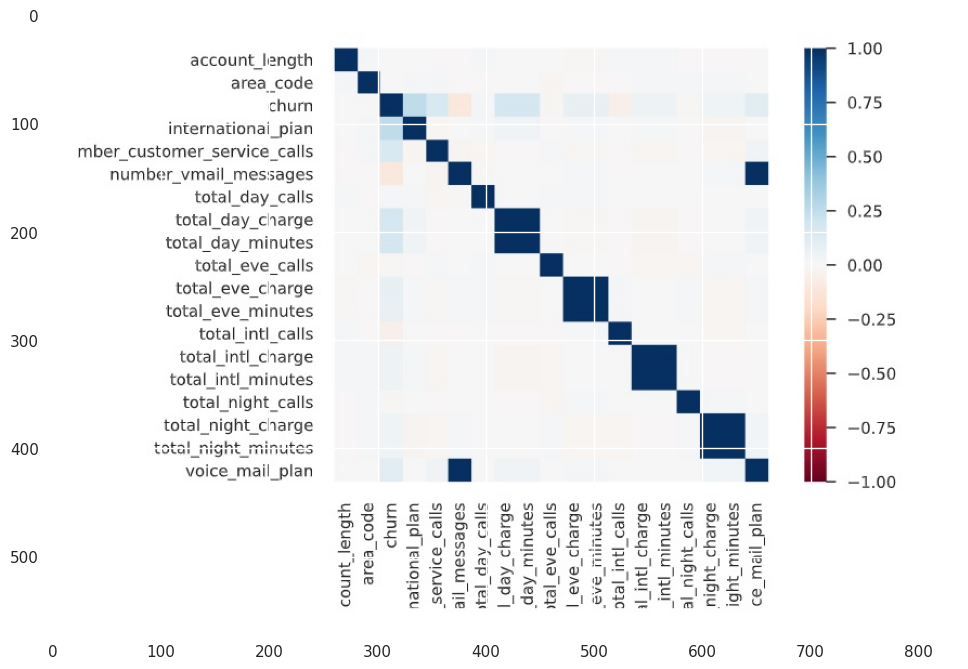

In [ ]:
#plots the image of the heatmap
img = mpimg.imread(path+'heatmap_report.jpg')
plt.imshow(img)
plt.show()

#3 Exploratory Data Analysis

##3.1 Univariate Analysis

In [ ]:
#removing target
df1 = train.drop(columns=['churn'])

#extracting kinds of features
numerical_features = df1.select_dtypes('number').columns.tolist()
categorical_features = df1.select_dtypes('object').columns.tolist()
target = 'churn'

#counting features of each kind
print(f'There are {len(numerical_features)} numerical features. They are: ')
print(numerical_features)
print(f'\nThere are {len(categorical_features)} categorical features. They are: ')
print(categorical_features)
print(f'\nThe target feature is: {target}.')

There are 15 numerical features. They are: 
['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']

There are 4 categorical features. They are: 
['state', 'area_code', 'international_plan', 'voice_mail_plan']

The target feature is: churn.


### 3.1.1 Numericals

Conclusions and insights regarding the numerical distribution were already done in the **section 2.4**

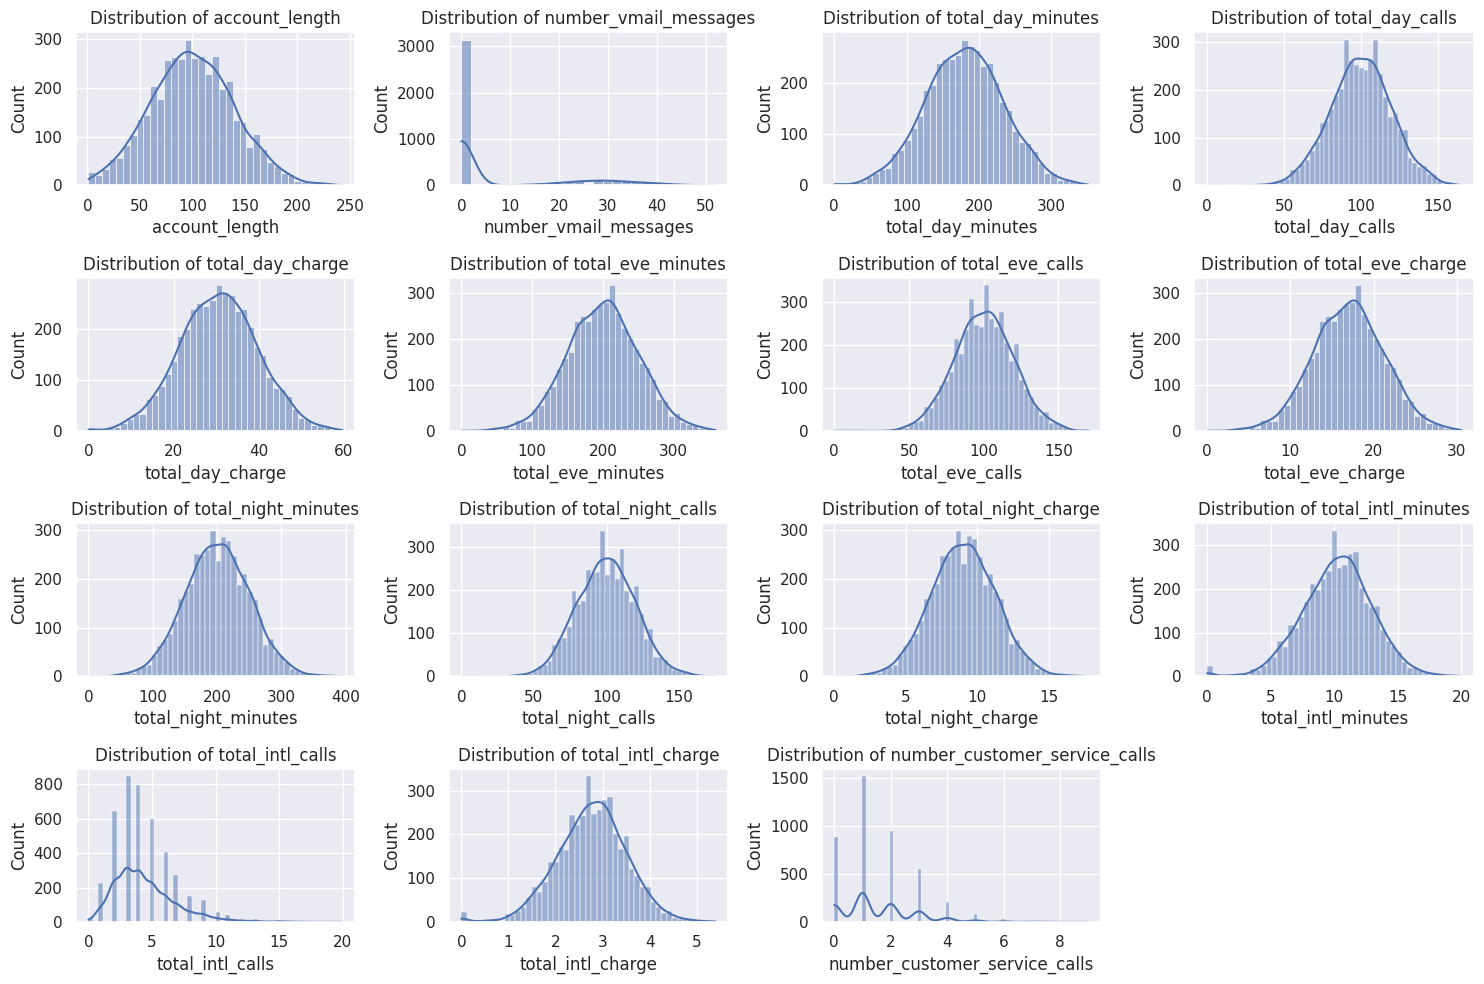

In [ ]:
plot_all_distributions(data=train, features=numerical_features)

###3.1.2 Categoricals

In [ ]:
#printing the proportion of categorical values of each categorical feature
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {train[feature].nunique()} unique values. They are: ')
    print(train[feature].value_counts(normalize=True))
    print()

state
----------------------------------------
There are 51 unique values. They are: 
state
WV    0.032706
MN    0.025412
ID    0.024941
AL    0.023765
VA    0.023529
OR    0.023294
TX    0.023059
UT    0.022824
NY    0.022588
NJ    0.022588
WY    0.022353
OH    0.022353
WI    0.022118
MA    0.020941
ME    0.020941
CT    0.020706
RI    0.020471
MI    0.020471
KS    0.020471
MD    0.020235
VT    0.020235
KY    0.020000
NV    0.019529
IN    0.019529
MS    0.019294
WA    0.018824
NC    0.018824
MO    0.018824
DE    0.018824
CO    0.018824
MT    0.018824
IL    0.018588
TN    0.018588
NM    0.018353
OK    0.018353
NH    0.018353
HI    0.018118
AZ    0.018118
FL    0.017882
SD    0.017647
NE    0.017176
DC    0.016941
SC    0.016941
AR    0.016706
LA    0.016235
PA    0.015765
ND    0.015765
GA    0.015059
IA    0.014588
AK    0.014353
CA    0.009176
Name: proportion, dtype: float64

area_code
----------------------------------------
There are 3 unique values. They are: 
area_code
area_code_

###3.1.3 Target

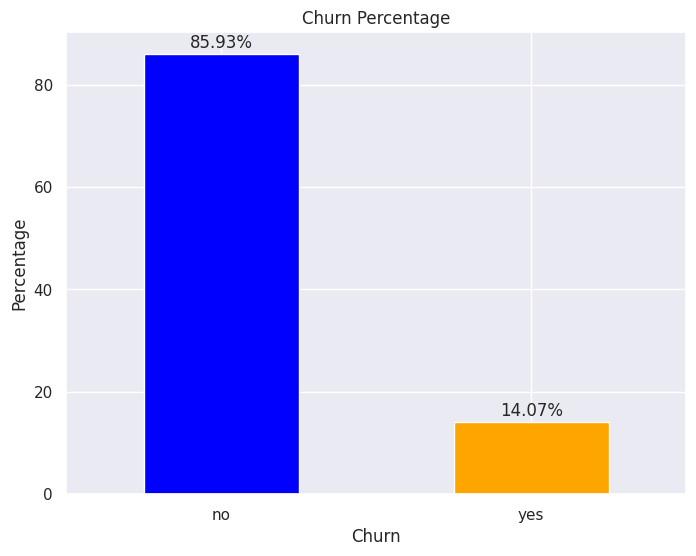

In [ ]:
#computing the percentage of values
churn_counts = train['churn'].value_counts(normalize=True) * 100

#ploting the distribution of values in percentage
plt.figure(figsize=(8, 6))
churn_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Churn Percentage')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
for i, v in enumerate(churn_counts):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

plt.show()

About **14% of customers** are churn, that is **around 595 customers** out of the total number of samples

###3.1.4 Outliers Analysis

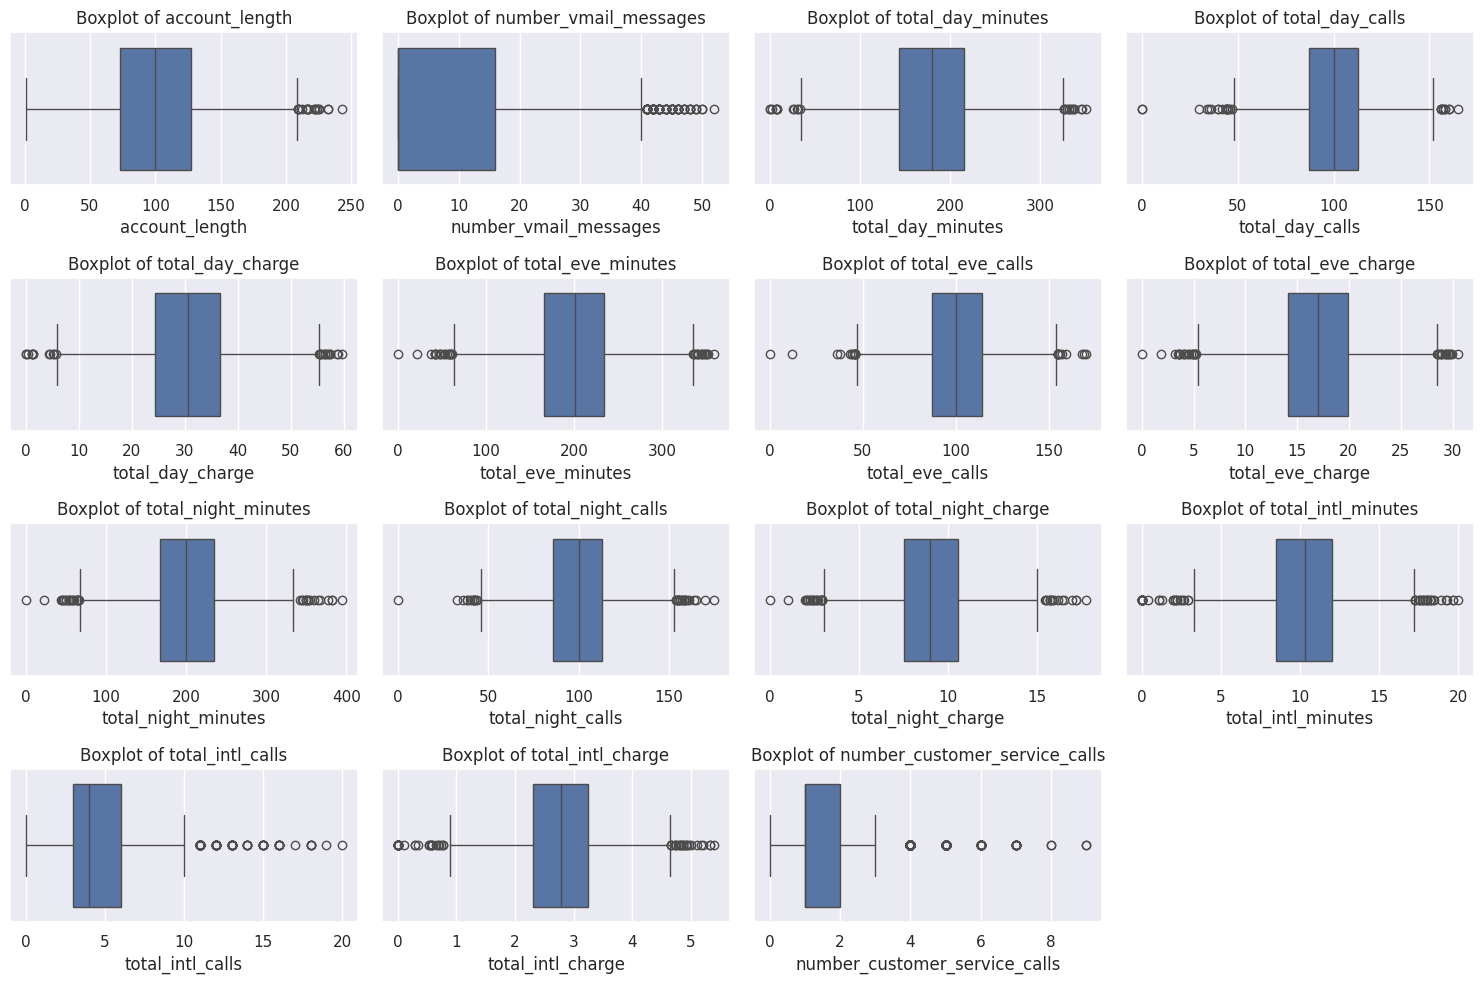

In [ ]:
#ploting all the boxplots
plot_all_boxplots(data=train, features=numerical_features)

In [ ]:
#ranking outliers proportions
calculate_percentage_outliers(data=train, features=numerical_features)

,%
number_customer_service_calls,7.882353
total_intl_calls,2.352941
number_vmail_messages,2.023529
total_intl_minutes,1.458824
total_intl_charge,1.458824
total_night_minutes,0.870588
total_night_charge,0.870588
total_eve_minutes,0.800000
total_eve_charge,0.800000
total_night_calls,0.776471


##3.2 Bivariate and multivariate analysis

###3.2.0 Correlation Rank & Heatmap

In [ ]:
corr_matrix = train.corr(numeric_only=True)
corr_matrix['churn'].sort_values(ascending=False)

churn                            1.000000
international_plan               0.259053
number_customer_service_calls    0.221220
total_day_minutes                0.215272
total_day_charge                 0.215263
total_eve_minutes                0.078855
total_eve_charge                 0.078852
total_intl_minutes               0.055186
total_intl_charge                0.055177
total_night_minutes              0.046647
total_night_charge               0.046641
account_length                   0.019378
total_day_calls                  0.011640
total_eve_calls                 -0.006817
total_night_calls               -0.012699
total_intl_calls                -0.034334
number_vmail_messages           -0.100347
Name: churn, dtype: float64

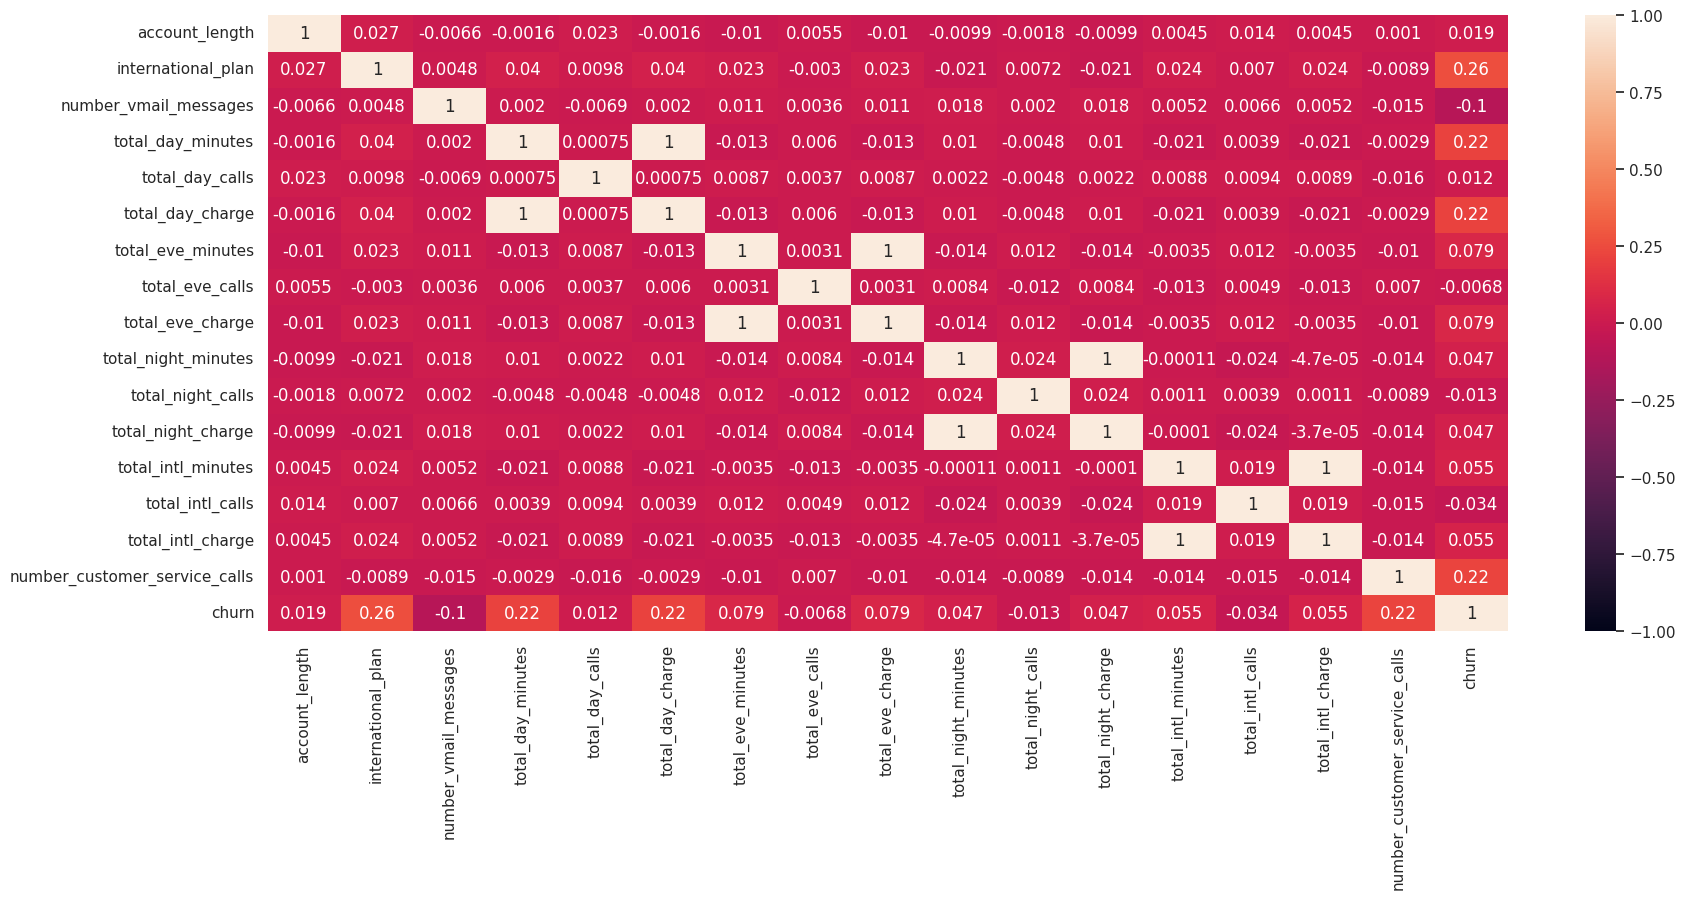

In [ ]:
#heatmap correlation
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
plt.show()

In this section, we will mainly set **hypothesis based on**:

*   **Correlation indicators** from the Section 2 [**Report**](https://drive.google.com/file/d/1RrC0SQ6Dn9qNqxYua9P9-WiZzg5t6blM/view?usp=drive_link)
*   The **article:** [*Determinants of churn in telecommunication services: a systematic literature review*](https://link.springer.com/article/10.1007/s11301-023-00335-7#Sec15) (section 4.2 of the article)
*   **Survey results:** [*Reason for Customer Churn in the Telecom Industry*](https://techsee.me/resources/reports/2019-telecom-churn-survey/)





**From the article, section 4.2:**

- "it could be argued that **service quality per se does not have a direct impact** on customer churn, but rather an indirect effect through satisfaction."

- "Looking at **switching costs and barriers**, we conclude that most studies agree **these factors are important in restricting consumers from changing operators**."

- "**Customers using more services** (more minutes, SMSs, mobile data, number of calls, among others) **tend to be less likely to churn**.

- However, it is necessary to keep in mind that, **consumer overspending positively impacts churn**"

- "The study also indicates that **customers who have bundled services are less likely to change operators**"

**From the survey:**

"**Customers canceled** their contracts for the following reasons:

- Companies wasted their time (**37% waited too long to have their issue resolved**)
- **They had to call more than once (51%)**"


---



**Hypothesys:**



1. The **more** clients make **Customer-service calls**, the **higher is the chance** of them **to cancel** their plans

2. The **higher is a client's daily charge**, the **more** he or she **tends to cancel**

3. The **more clients send voice-mail messages**, the **less they tend to cancel**

4. Clients **with international plan tend to cancel rather than the ones without it**





###3.2.1 H1: The more clients make Customer-service calls, the higher is the chance of them to cancel their plans

**True:** It's clear that by 4 calls, a customer is much more likely to cancel

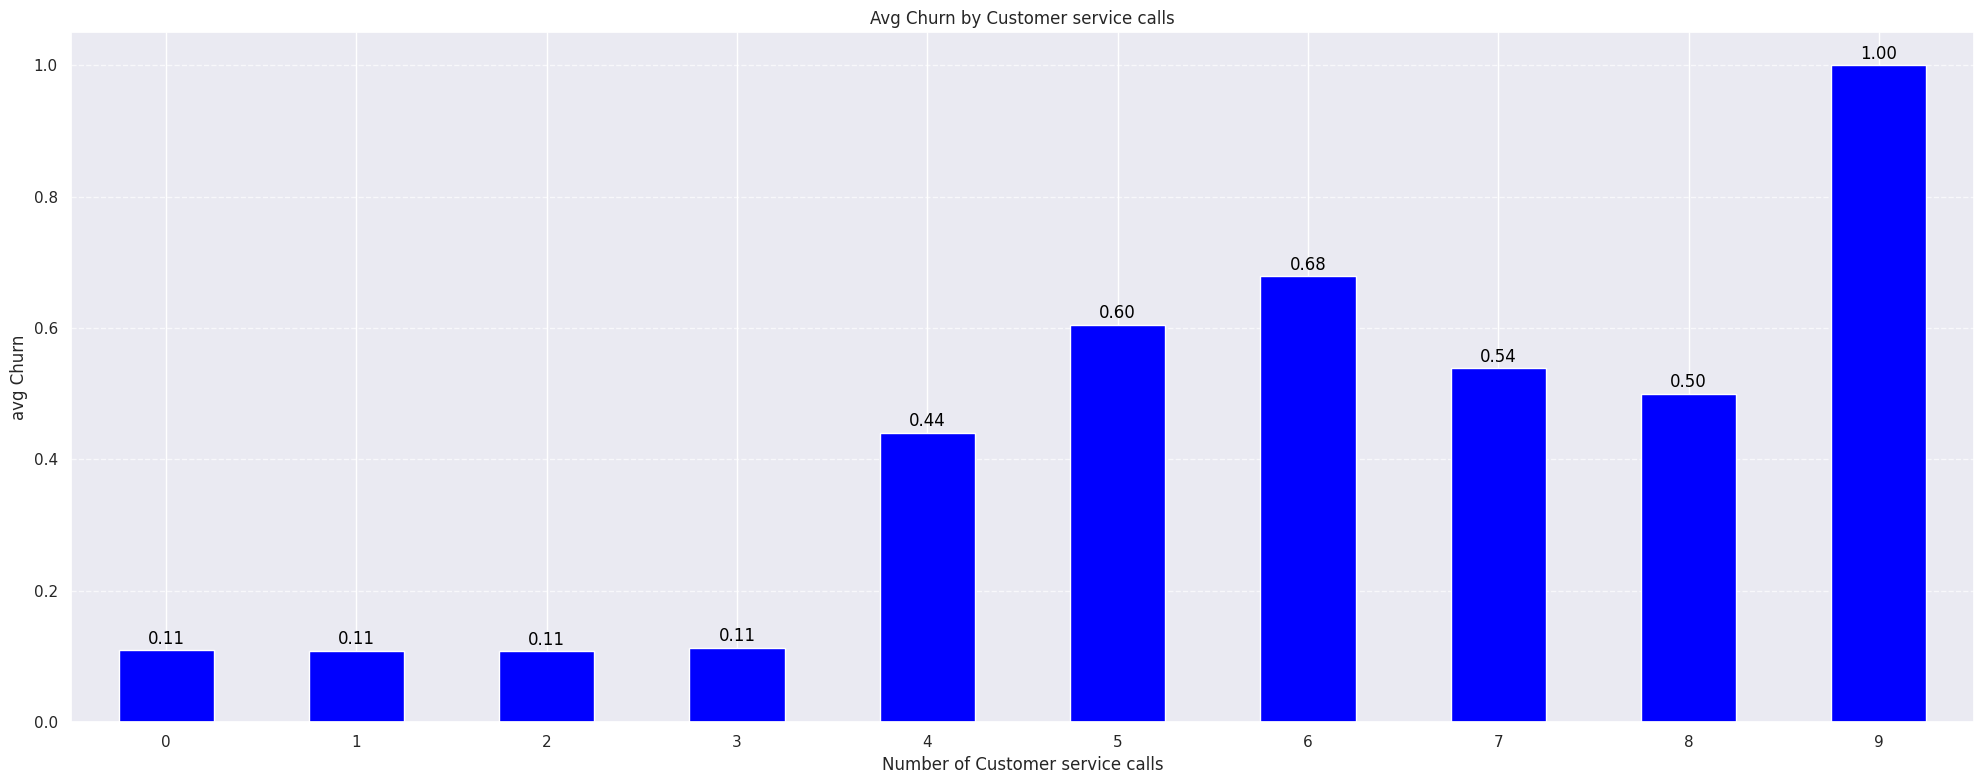

In [ ]:
mean_churn_by_calls = train.groupby('number_customer_service_calls')['churn'].mean()

mean_churn_by_calls.plot(kind='bar', color='blue')
plt.title('Avg Churn by Customer service calls')
plt.xlabel('Number of Customer service calls')
plt.ylabel('avg Churn')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_by_calls):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()

###3.2.2 H2: The higher is a client's daily charge, the more he or she tends to cancel

**True:** From approximately 40 dollars as total day charge, the likelihood of customer canceling increases significantly and steadily

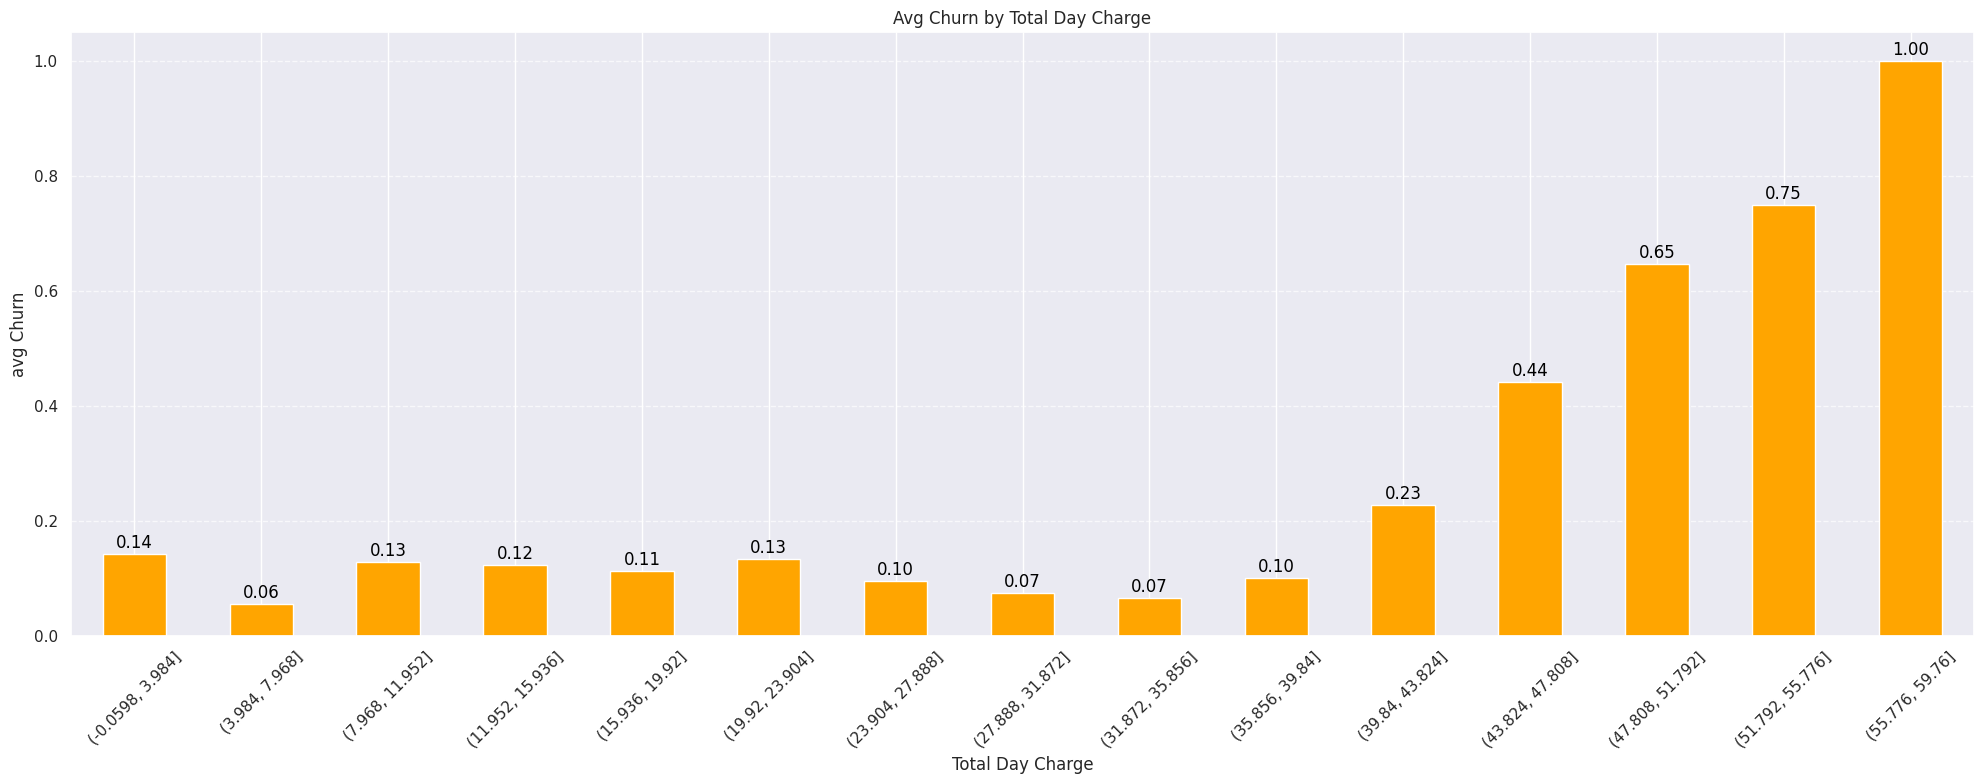

In [ ]:
mean_churn = train.groupby(pd.cut(train['total_day_charge'], bins=15))['churn'].mean()

mean_churn.plot(kind='bar', color='orange')
plt.xlabel('Total Day Charge')
plt.ylabel('avg Churn')
plt.title('Avg Churn by Total Day Charge')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()

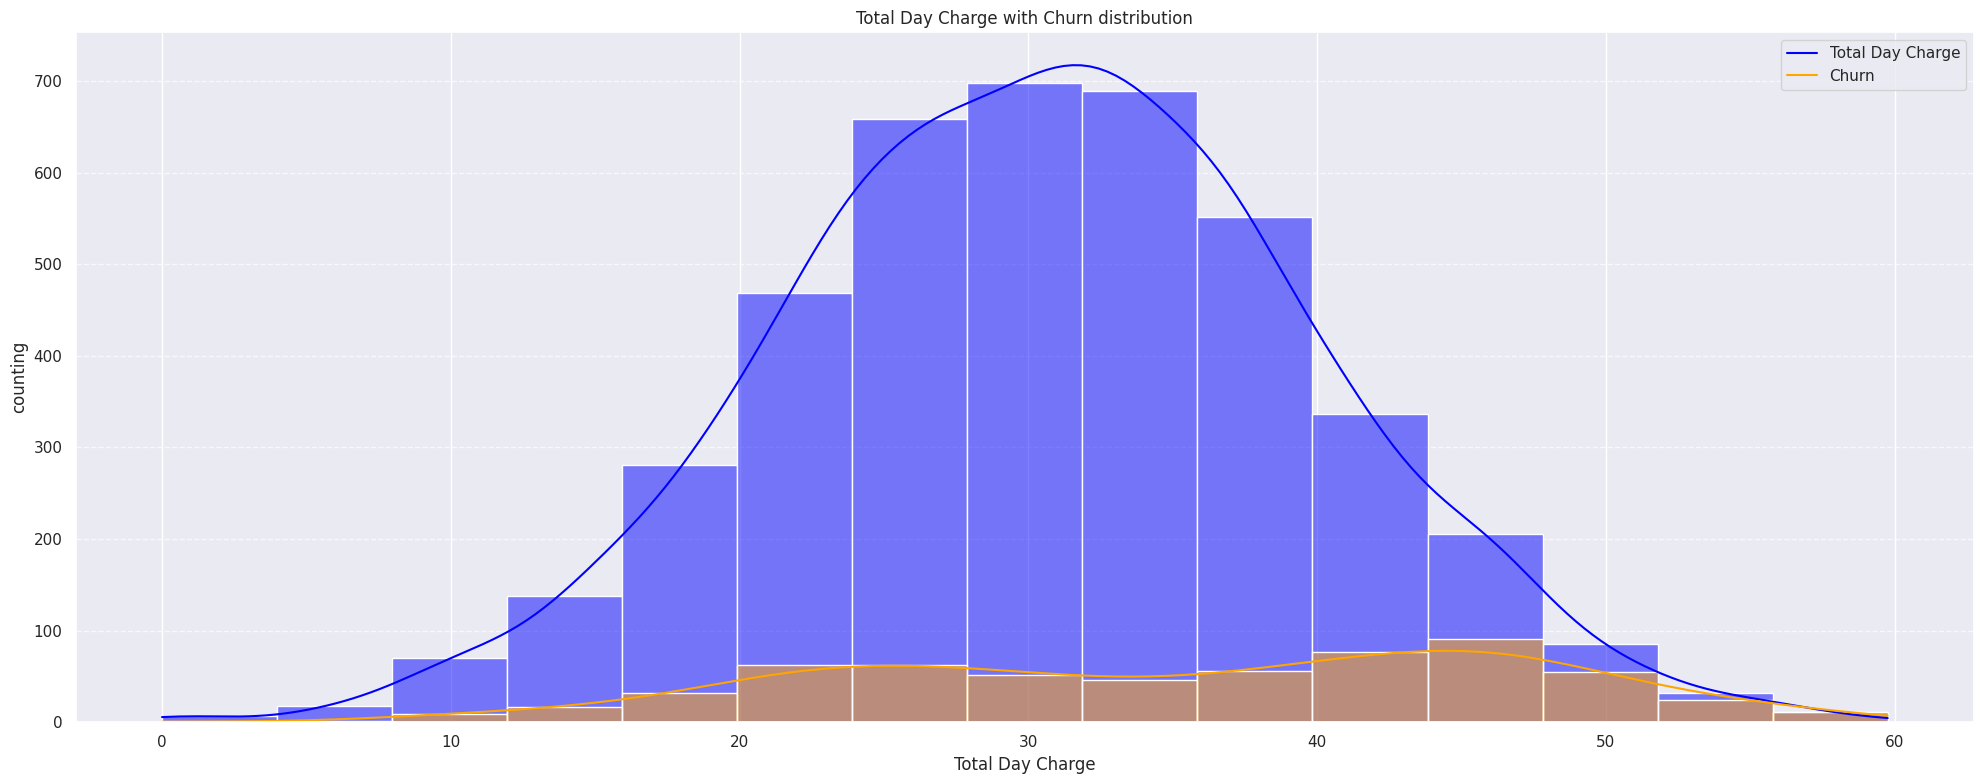

In [ ]:
sns.histplot(train['total_day_charge'], bins=15, color='blue', kde=True)
sns.histplot(train[train['churn'] == 1]['total_day_charge'], bins=15, color='orange', kde=True, alpha=0.5)
plt.xlabel('Total Day Charge')
plt.ylabel('counting')
plt.title('Total Day Charge with Churn distribution')
plt.legend(['Total Day Charge', 'Churn'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

###3.2.3 H3: The more clients send voice-mail messages, the less they tend to cancel

**False:** there's no clear correlation between the variables

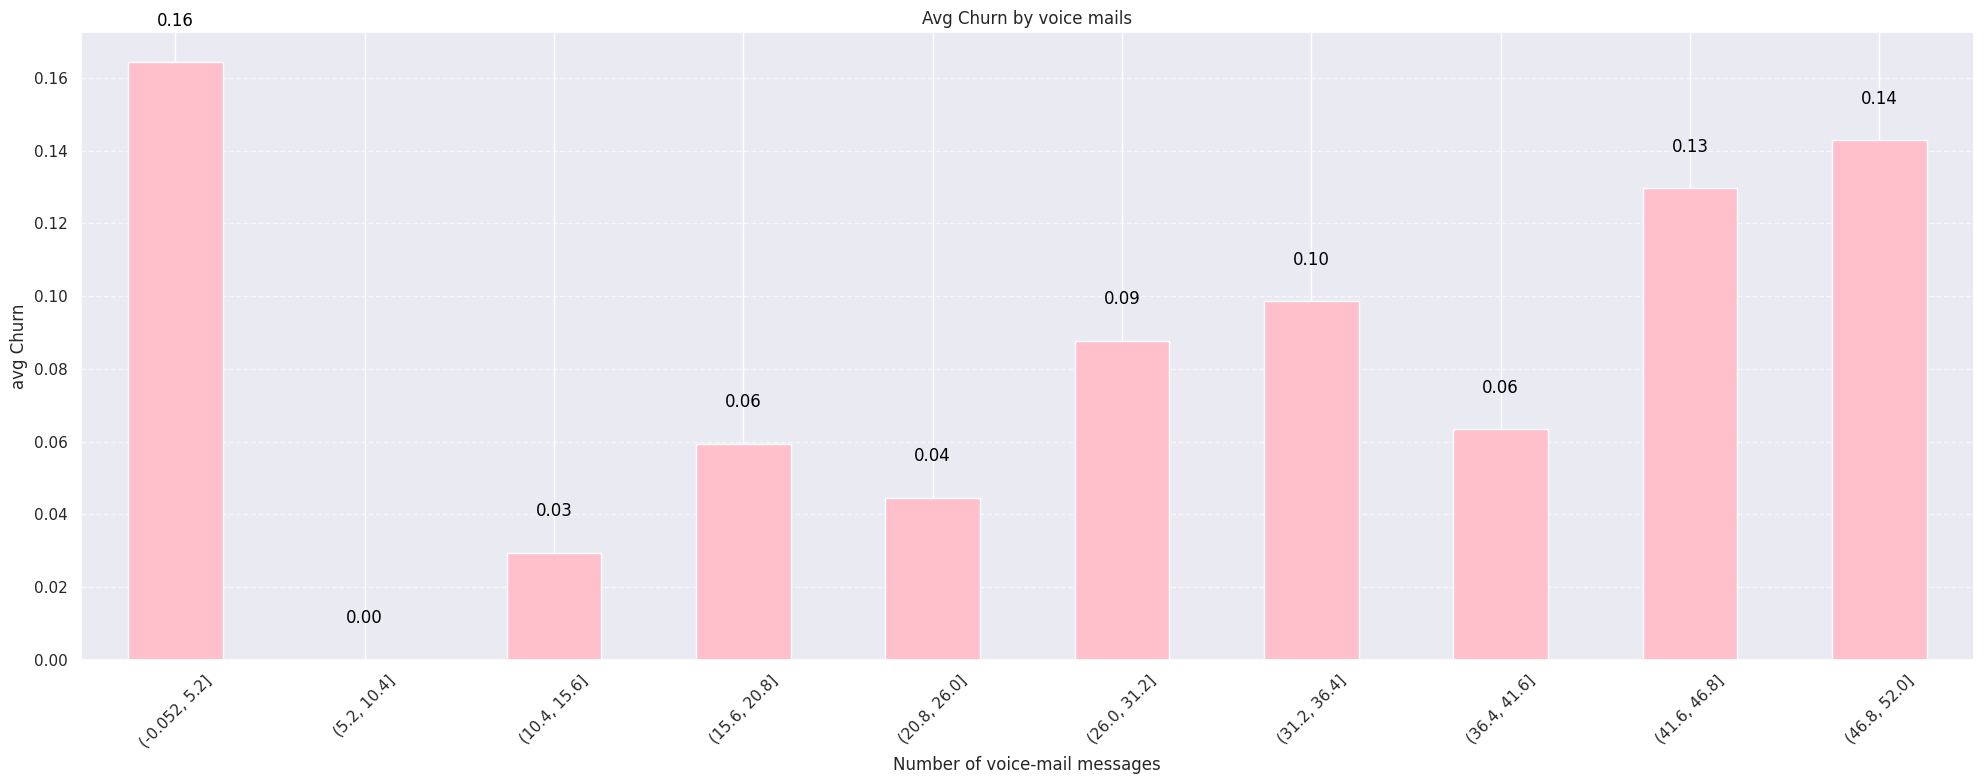

In [ ]:
mean_churn_by_vmails = train.groupby(pd.cut(train['number_vmail_messages'], bins=10))['churn'].mean()

mean_churn_by_vmails.plot(kind='bar', color='pink')
plt.title('Avg Churn by voice mails')
plt.xlabel('Number of voice-mail messages')
plt.ylabel('avg Churn')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_by_vmails):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()

### 3.2.4 H4: Clients with international plan tend to cancel rather than the ones without it

**True:** More than 40% of clients with International plan cancel, while around only 10% of clients without the plan cancel

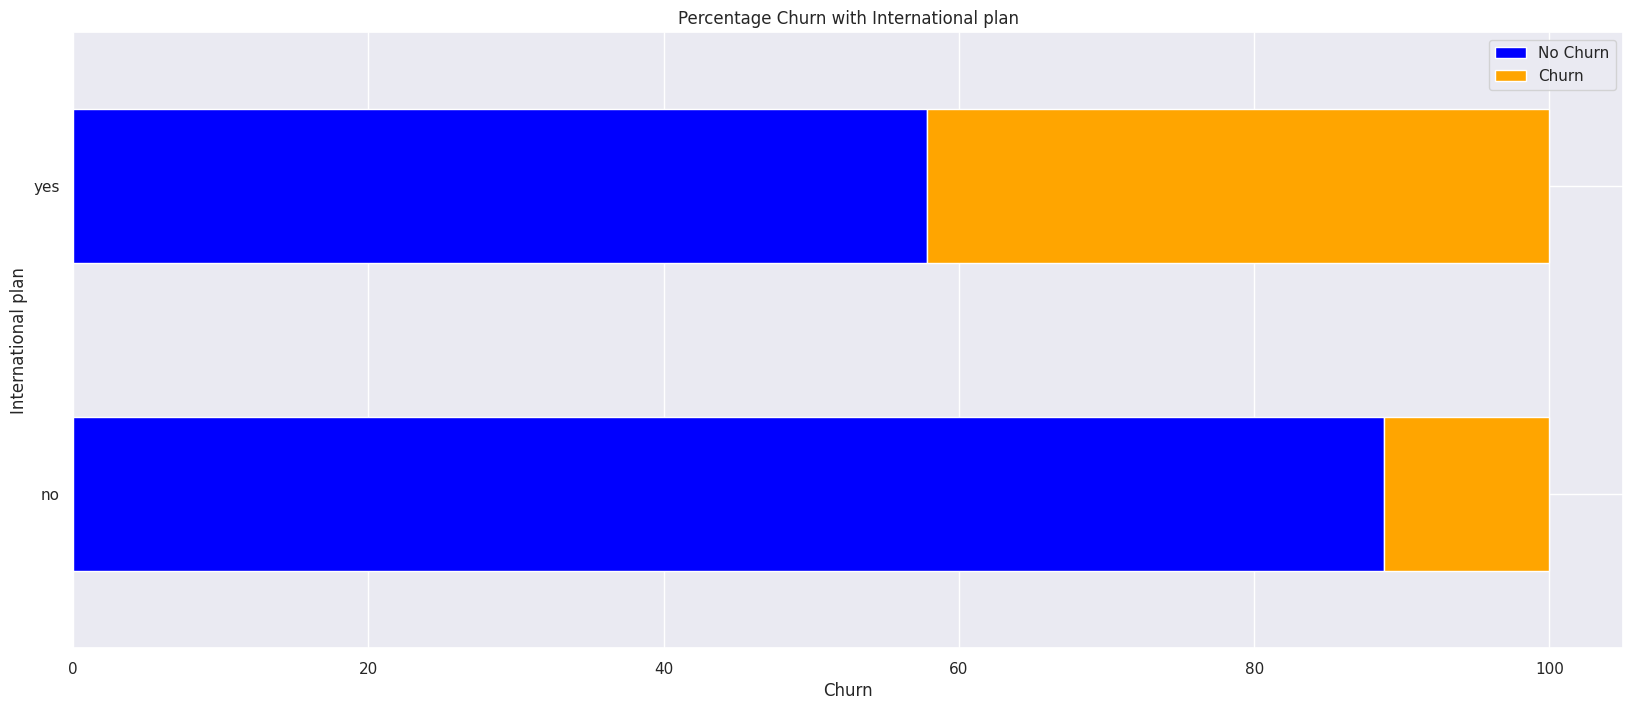

In [ ]:
churn_count = train.groupby('international_plan')['churn'].value_counts().unstack()

churn_percentage = churn_count.div(churn_count.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots()

churn_percentage.plot(kind='barh', stacked=True, ax=ax, color=[ 'blue', 'orange'])

ax.set_xlabel('Churn')
ax.set_ylabel('International plan')
ax.set_title('Percentage Churn with International plan')
ax.legend(['No Churn', 'Churn'])

plt.show()

##3.3 EDA Conclusions

###3.3.1 Conclusions

**TRUE:**

*   The more clients make Customer-service calls, the higher is the chance of them to cancel their plans
*   The higher is a client's daily charge, the more he or she tends to cancel
*   Clients with international plan tend to cancel rather than the ones without it

**FALSE:**
*   The more clients send voice-mail messages, the less they tend to cancel







---



**INSIGHTS:**



*   Customers who **call 4 times or more customer service are much more likely to cancel** (increasing steadily)

*   The **likelihood of a customer cancelling increases significantly** if he or she is **charged over 40 dollars daily**

*   Customers **with international plan are 4 times more likely to cancel**

*  **Outliers may give important information about the likelihood** of a customers **being a churn** (Ex: Number of Customer Service Calls, total number of International minutes)





###3.3.2 Further Analysis

As total day charge presented correlation with customer cancelling, and this feature is related to others that also presented a higher correlation with the churn variable itself. It was thought about observing further the relationship of such variables with the churn itself, just like we did with Total Day Charge:

**Average Churn by total evening Minutes and Charge**

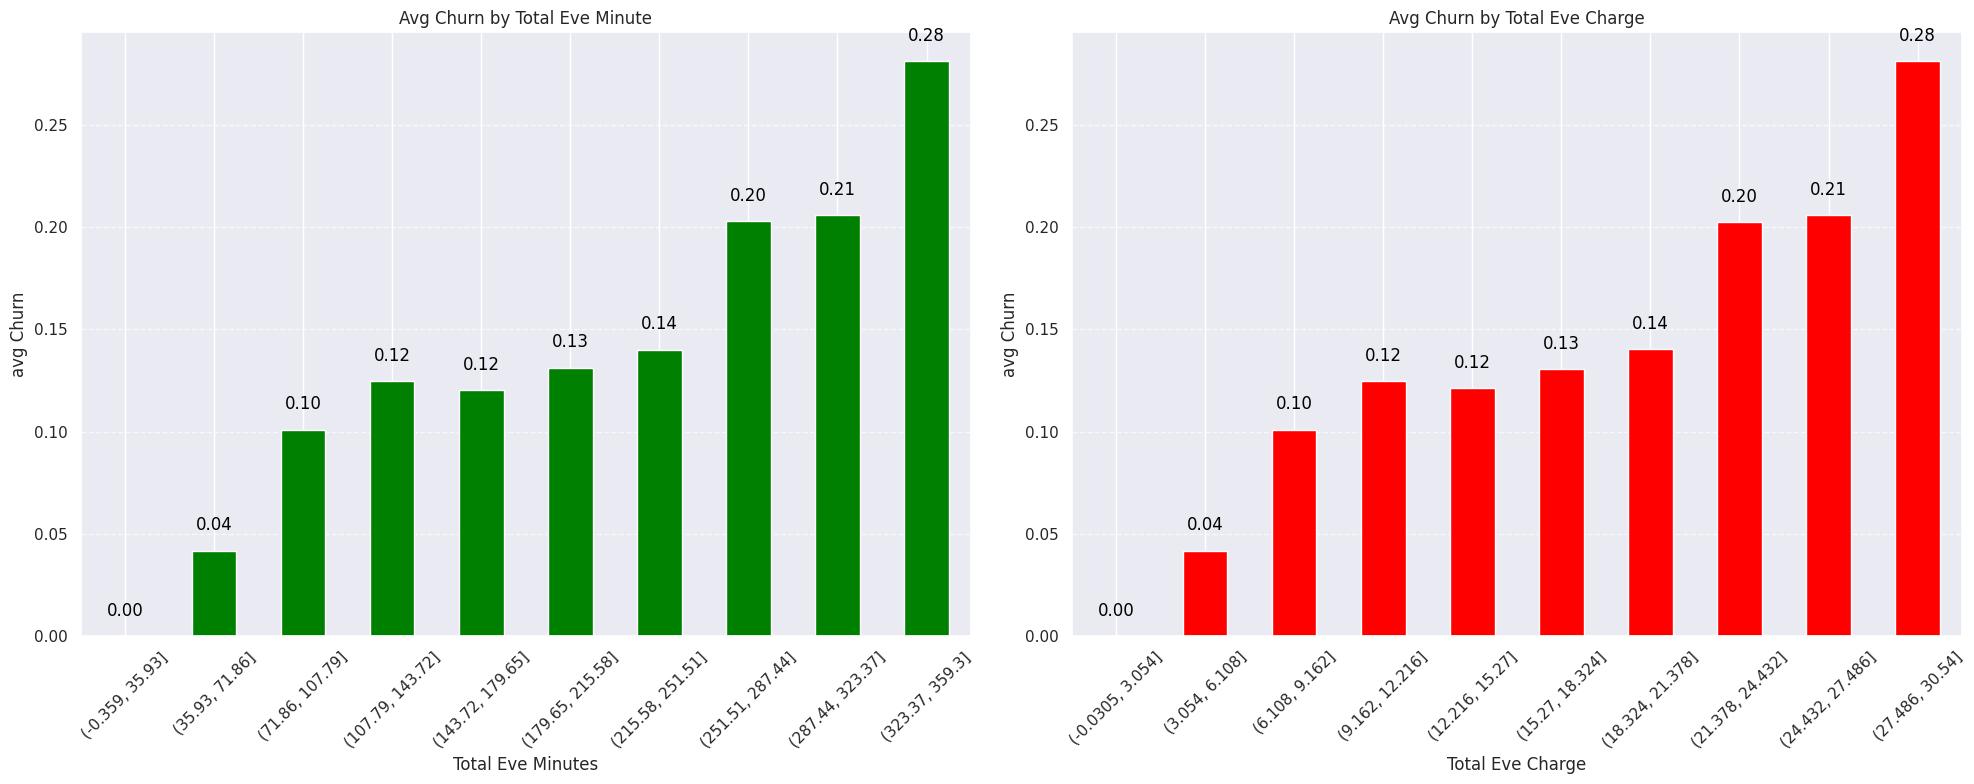

In [ ]:
#total eve minutes
mean_churn_x = train.groupby(pd.cut(train['total_eve_minutes'], bins=10))['churn'].mean()

plt.subplot(1,2,1)
mean_churn_x.plot(kind='bar', color='Green')
plt.xlabel('Total Eve Minutes')
plt.ylabel('avg Churn')
plt.title('Avg Churn by Total Eve Minute')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_x):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')


#total eve charge
mean_churn_y = train.groupby(pd.cut(train['total_eve_charge'], bins=10))['churn'].mean()

plt.subplot(1,2,2)
mean_churn_y.plot(kind='bar', color='red')
plt.xlabel('Total Eve Charge')
plt.ylabel('avg Churn')
plt.title('Avg Churn by Total Eve Charge')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_y):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()

**Average Churn by total day Minutes and Charge**

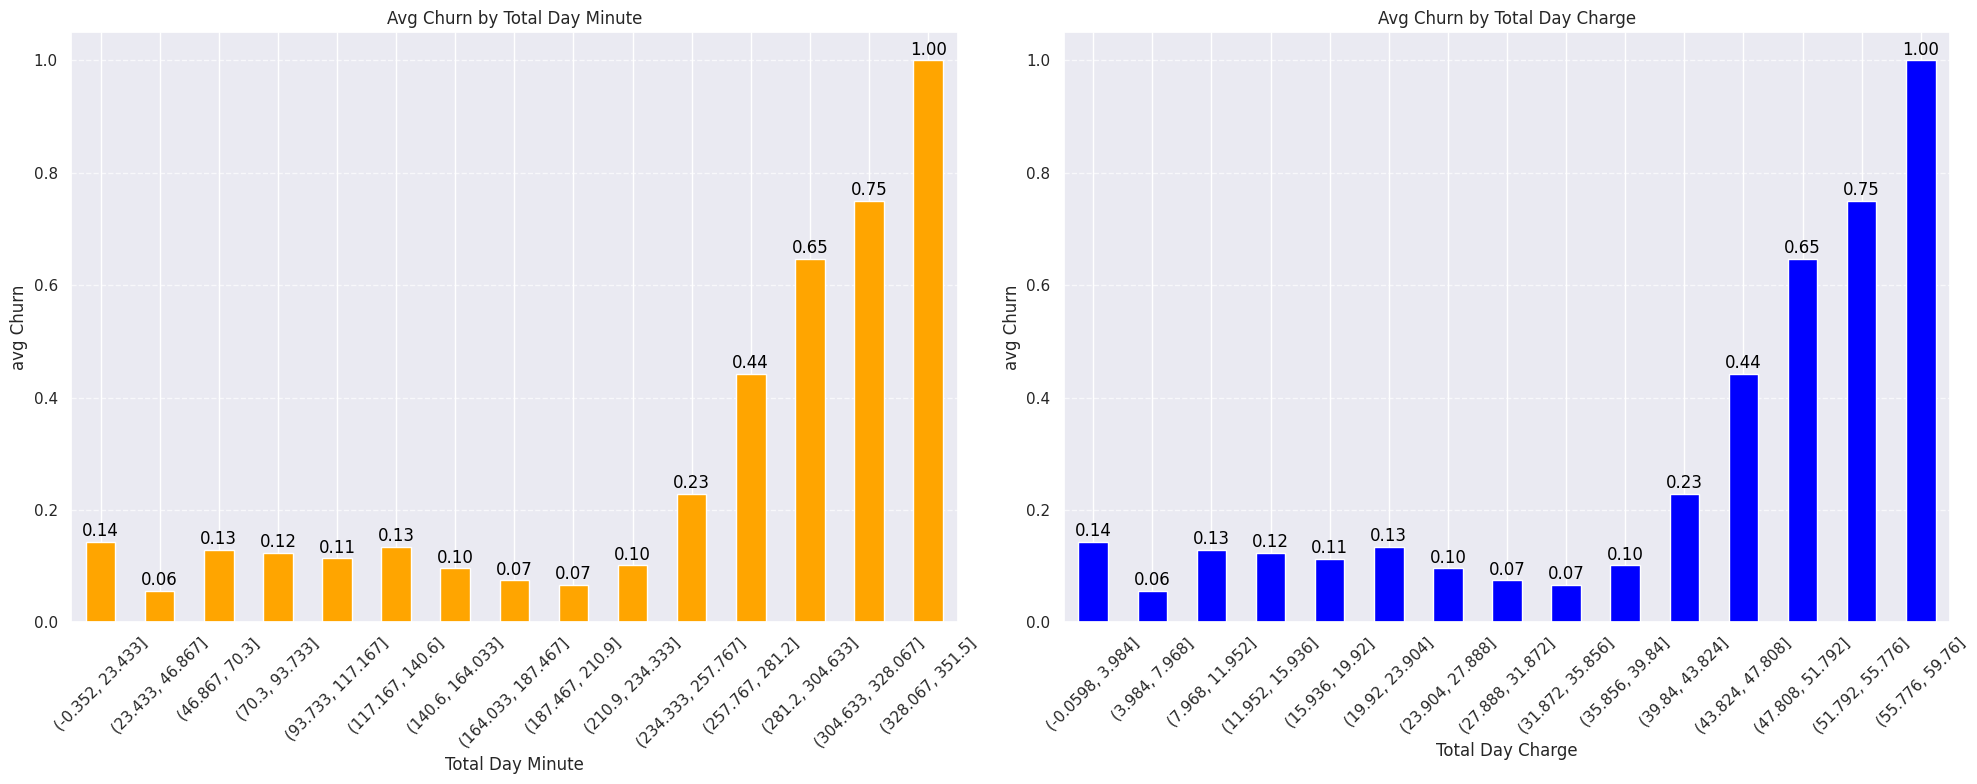

In [ ]:
#total day minutes
mean_churn_x = train.groupby(pd.cut(train['total_day_minutes'], bins=15))['churn'].mean()

plt.subplot(1,2,1)
mean_churn_x.plot(kind='bar', color='orange')
plt.xlabel('Total Day Minute')
plt.ylabel('avg Churn')
plt.title('Avg Churn by Total Day Minute')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_x):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

#total day charge
mean_churn_y = train.groupby(pd.cut(train['total_day_charge'], bins=15))['churn'].mean()

plt.subplot(1,2,2)
mean_churn_y.plot(kind='bar', color='blue')
plt.xlabel('Total Day Charge')
plt.ylabel('avg Churn')
plt.title('Avg Churn by Total Day Charge')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_y):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()

**Churn by area code**

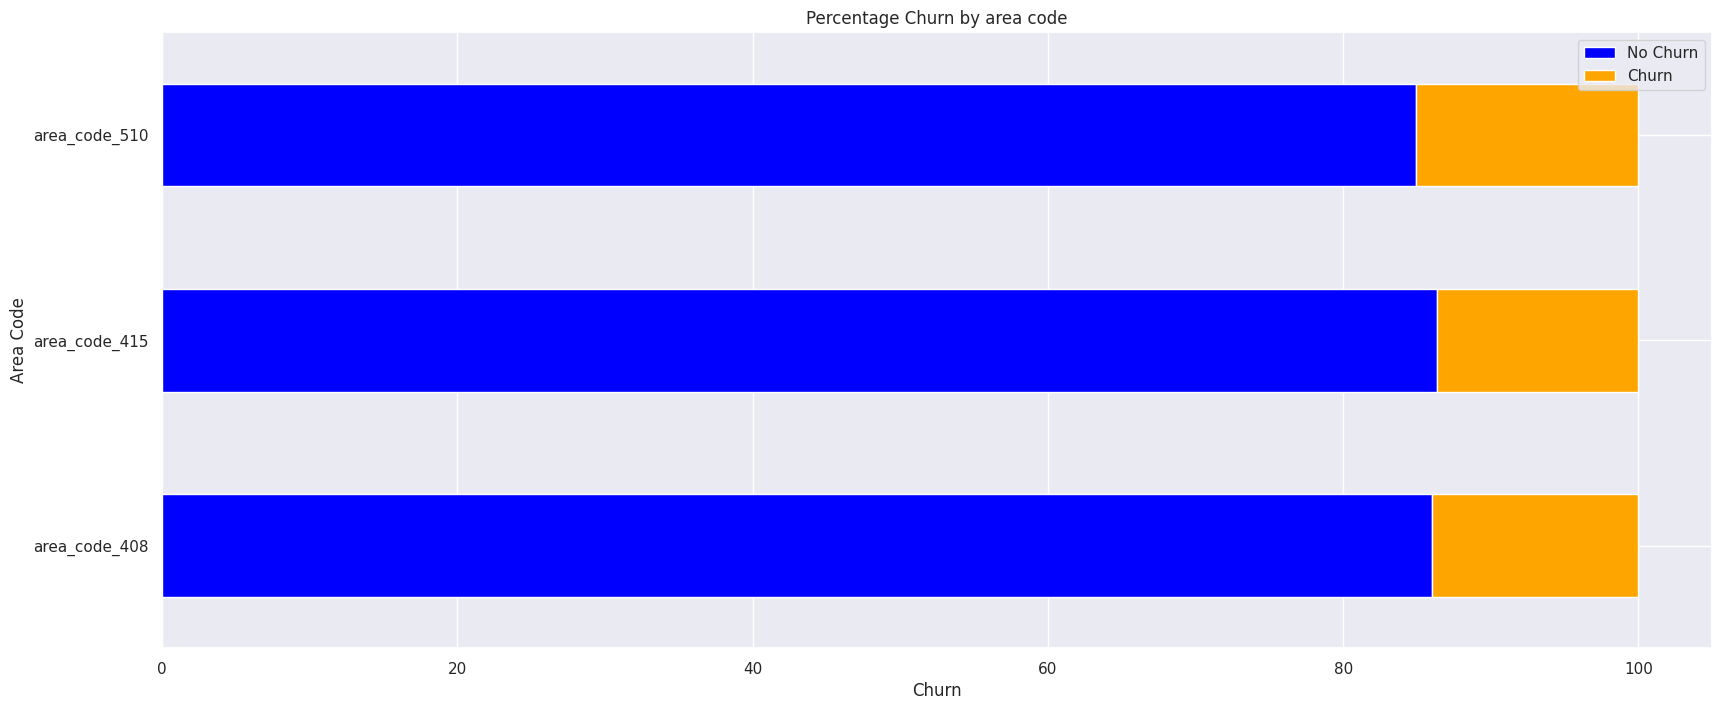

In [ ]:
churn_count = train.groupby('area_code')['churn'].value_counts().unstack()

churn_percentage = churn_count.div(churn_count.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots()

churn_percentage.plot(kind='barh', stacked=True, ax=ax, color=[ 'blue', 'orange'])

ax.set_xlabel('Churn')
ax.set_ylabel('Area Code')
ax.set_title('Percentage Churn by area code')
ax.legend(['No Churn', 'Churn'])

plt.show()

**Churn by Account Length**

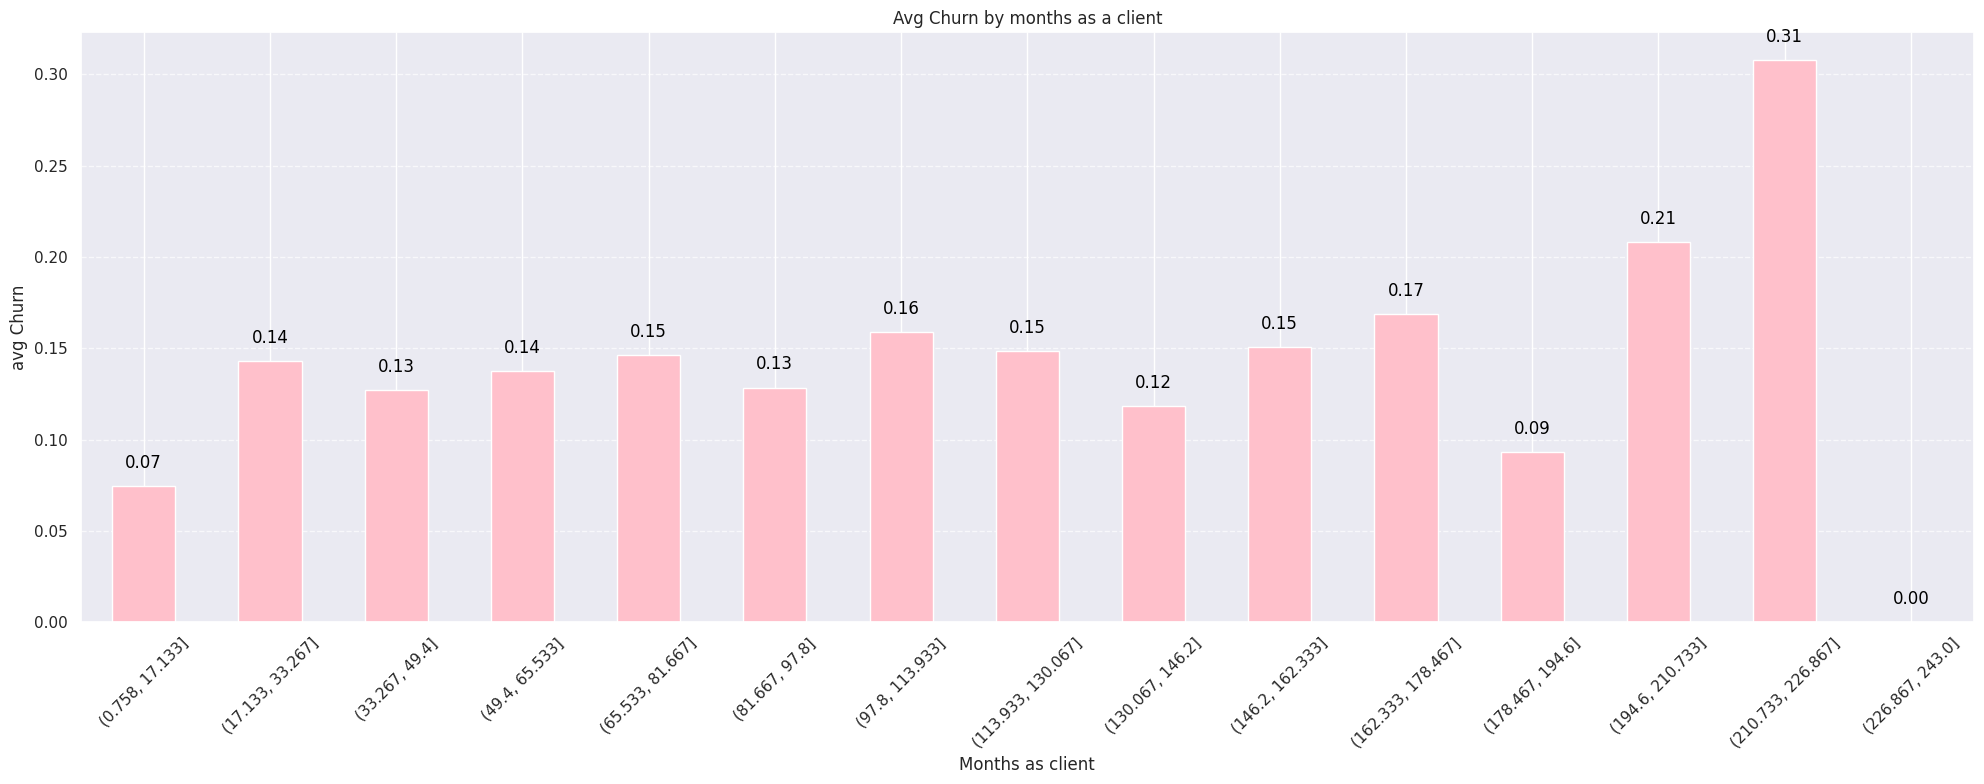

In [ ]:
mean_churn_y = train.groupby(pd.cut(train['account_length'], bins=15))['churn'].mean()

mean_churn_y.plot(kind='bar', color='pink')
plt.xlabel('Months as client')
plt.ylabel('avg Churn')
plt.title('Avg Churn by months as a client')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(mean_churn_y):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', color='black')

plt.tight_layout()
plt.show()



---



**Further Insights:**



*   Just like it was found out in the hypothesis 2. Both **the total day charge** and the **amount of minute spent on day calls play a great role in the likelihood of a customer cancelling**. Apart from being very similar in its influence and behavior, by the graph it is possible to spot that **by around 235 minutes and 40 dollars, the likelihood of churn grows steadily**, being critical values.

*   Not only that, the graph shows **all customers who spent around 328 minutes or more, and 56 dollars or more ended up cancelling their accounts**



*   **Evening calls** (charge and minutes, play a less important role, however, noticeably, also **customers the more they spend, the more likely are they to cancel** even though it doesn't grow steadily

*   According to the chart, **around 1 in each 5 customers who spent more than 252 minutes and 22 dollars on evening calls cancels**


*   **Area code** seems to have **no influence** whether a customer will cancel or not


*   Although there's a peak of churns with clients between 210 and 227 months of account. Chart shows there's **no actual relation** between these 2 variables **(account length & churn)**










#4 Preparing the Model

##4.0 Strategies to build the model

Firstly, as many variables involve the amount of charge, calls and minutes related to customers' consumption, it is thought to be created **3 variables that combine all of these aspects as part of feature engineering process**:

*   total_charge
*   total_minutes
*   total_calls



I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more existing customers than attrited ones.

Also, I will firstly **split the data** in order to avoid data leakage between the train and the test datasets. The data will be split by 20% for testing which will be important for the cross-validation stage later



---



Before applying the ML algorithms, there are some transformations the dataset to be trained needs  to go through:



1.  **Remove redundant information** - Several features according to the correlation matrix share very similar data, therefore, some features will be removed due to its full correlation with at least another feature of the dataset:


*   total_day_minutes
*   total_eve_minutes
*   total_night_minutes
*   total_intl_minutes
*   total_day_calls
*   total_eve_calls
*   total_night_calls
*   total_intl_calls






2.   **Encoding categorical variables** - 3 variables will be encoded binarily, since their values are only "yes" or "no", we'll simply substitute these values for 1 and 0:

*   international_plan
*   voice_mail_plan
*   churn (target)


The other categorical features will go through [specified encoding](
https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b)

*   state (one-hot encoding)
*   area_code (hashing encoding)



3.   **Scalling and Normalization** - Scalling the numerical variables usually [helps to ML algorithms performance](https://medium.com/@arulkumarark1924/handling-numerical-data-f7f5b0efc088). For this step, the distributions observed in the sections 3.1.1 and in the report generated will be considered, being:

*   MinMaxScaler (all data)
*   StandardScaler (normal-distributed data)



---



After the steps above, we should be ready to apply the ML algorithms for the 1st time, as our baseline

4.   **Apply the ML algorithms for the 1st time as baseline** - Based on the nature of classification, we'll be testing 5 different algorithms:

*   decision tree
*   random forest
*   logistic regression
*   SVM
*   lightGBM

They were chosen due to its differencies which implicates variety when attempting to better interpret this project phenomenom.



---



After setting a baseline, it's time to perform the first transformations in the training dataset in order **to test if they achieve a better accuracy**

5.   **Apply with treated outliers** - The outliers will be addressed using the [capping method](https://towardsdatascience.com/dont-throw-away-your-outliers-c37e1ab0ce19)


6.   **Apply with upsampling** - Since churn variable is imbalamced, algorithms might perform better in case we create samples and balance tthe target

7.   **Apply with Feature selection** - The problem definitely involve more features than the actual necessary. Selecting the features that are better related to the target also in fact add information tends stringly to help the algorithms ´perform better. Therefore it will be applied 3 methods before making a final list of the best features. [Those methods were selected as the following](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/):

*   Mutual-info (it measures how features add to the target classification)
*   Tree-based (the tree ML algorithms itself help sort which variables are more relevant)
*   RFE (Wrapper method, external estimator that assigns weights to features)


8.   **Apply with all treatments combines** - As final comparison with the baseline we will apply the algorithms with all treatments combined. Depending on the performance of algorithms after certain treatments, they will be discarded or not.







---



After comparing all results with the baseline and deciding the best algorithms and preparation to the model itself, it's time to better assess the chosen model and settings



9.   **K-fold Cross Validation** - We'll sample the data in 5 groups and perform this validation


10.  **Understand the results and communicate** - Now we finally check if the goals of this project were met and the main insights extracted about what makes a customer cancel and how to avoid it



##4.1 Feature engineering

In [ ]:
train['total_minutes'] = train['total_day_minutes'] + train['total_eve_minutes'] + train['total_night_minutes']
train['total_calls'] = train['total_day_calls'] + train['total_eve_calls'] + train['total_night_calls']
train['total_charge'] = train['total_day_charge'] + train['total_eve_charge'] + train['total_night_charge']

In [ ]:
redundant_cols = ['total_day_minutes',
                  'total_eve_minutes',
                  'total_night_minutes',
                  'total_intl_minutes',
                  'total_day_calls',
                  'total_eve_calls',
                  'total_night_calls',
                  'total_intl_calls']

train.drop(columns=redundant_cols, inplace=True)

In [ ]:
train

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge
0,OH,107,area_code_415,no,yes,26,27.47,16.62,11.45,3.70,1,no,611.5,329,55.54
1,NJ,137,area_code_415,no,no,0,41.38,10.30,7.32,3.29,0,no,527.2,328,59.00
2,OH,84,area_code_408,yes,no,0,50.90,5.26,8.86,1.78,2,no,558.2,248,65.02
3,OK,75,area_code_415,yes,no,0,28.34,12.61,8.41,2.73,3,no,501.9,356,49.36
4,MA,121,area_code_510,no,yes,24,37.09,29.62,9.57,2.03,3,no,779.3,314,76.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,32.01,20.72,9.62,2.78,0,no,645.8,237,62.35
4246,WV,73,area_code_408,no,no,0,30.24,11.15,8.38,3.11,3,no,495.3,260,49.77
4247,NC,75,area_code_408,no,no,0,29.02,16.41,5.81,1.86,1,no,492.9,331,51.24
4248,HI,50,area_code_408,no,yes,40,40.07,18.96,13.39,2.67,2,no,756.2,369,72.42


##4.2 Split Data

In [ ]:
X = train.drop(columns=['churn'])
y = train['churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##4.3 Encoding

In [ ]:
#tranforming important values to numeric values
mapping = {'yes': 1, 'no': 0}
y_test = y_test.map(mapping)
y_train = y_train.map(mapping)
X_train['international_plan'] = X_train['international_plan'].map(mapping)
X_test['international_plan'] = X_test['international_plan'].map(mapping)
X_train['voice_mail_plan'] = X_train['voice_mail_plan'].map(mapping)
X_test['voice_mail_plan'] = X_test['voice_mail_plan'].map(mapping)

In [ ]:
#converting all state into smaller number of different categories due to dimensionality issues
hash_state = ce.HashingEncoder(cols = 'state')
X_train = hash_state.fit_transform(X_train)
X_test = hash_state.transform(X_test)

In [ ]:
# converting the area_code to numerical variable using one-hot encoder
onehot_area = OneHotEncoder()
onehot_area.fit(X_train[['area_code']])
onehot_area.fit(X_test[['area_code']])

# Train
encoded_values = onehot_area.transform(X_train[['area_code']])
X_train[onehot_area.categories_[0]] = encoded_values.toarray()
X_train = X_train.drop('area_code', axis=1)

# Test
encoded_values = onehot_area.transform(X_test[['area_code']])
X_test[onehot_area.categories_[0]] = encoded_values.toarray()
X_test = X_test.drop('area_code', axis=1)

In [ ]:
print(X_test.info())
X_test.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 850 entries, 3382 to 3790
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   col_0                          850 non-null    int64  
 1   col_1                          850 non-null    int64  
 2   col_2                          850 non-null    int64  
 3   col_3                          850 non-null    int64  
 4   col_4                          850 non-null    int64  
 5   col_5                          850 non-null    int64  
 6   col_6                          850 non-null    int64  
 7   col_7                          850 non-null    int64  
 8   account_length                 850 non-null    int64  
 9   international_plan             850 non-null    int64  
 10  voice_mail_plan                850 non-null    int64  
 11  number_vmail_messages          850 non-null    int64  
 12  total_day_charge               850 non-null    floa

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,account_length,international_plan,...,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls,total_minutes,total_calls,total_charge,area_code_408,area_code_415,area_code_510
3382,1,0,0,0,0,0,0,0,43,0,...,11.22,14.54,2.89,0,621.0,263,53.95,0.0,1.0,0.0
1109,0,0,0,0,1,0,0,0,103,0,...,21.56,9.71,1.73,1,610.7,306,55.29,0.0,1.0,0.0
579,0,0,0,1,0,0,0,0,156,0,...,15.16,7.61,2.03,1,526.4,268,53.17,0.0,1.0,0.0


In [ ]:
print(X_train.info())
X_train.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 3400 entries, 3835 to 692
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   col_0                          3400 non-null   int64  
 1   col_1                          3400 non-null   int64  
 2   col_2                          3400 non-null   int64  
 3   col_3                          3400 non-null   int64  
 4   col_4                          3400 non-null   int64  
 5   col_5                          3400 non-null   int64  
 6   col_6                          3400 non-null   int64  
 7   col_7                          3400 non-null   int64  
 8   account_length                 3400 non-null   int64  
 9   international_plan             3400 non-null   int64  
 10  voice_mail_plan                3400 non-null   int64  
 11  number_vmail_messages          3400 non-null   int64  
 12  total_day_charge               3400 non-null   floa

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,account_length,international_plan,...,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls,total_minutes,total_calls,total_charge,area_code_408,area_code_415,area_code_510
3835,1,0,0,0,0,0,0,0,166,0,...,20.64,9.15,2.70,4,684.7,320,70.35,0.0,1.0,0.0
1518,0,0,0,0,0,1,0,0,125,1,...,13.66,11.87,2.59,0,611.8,341,57.37,0.0,1.0,0.0
1704,1,0,0,0,0,0,0,0,89,0,...,16.12,7.69,3.43,0,466.4,360,41.81,1.0,0.0,0.0


It seems that one hot transform the data into float, when it should transform into ints, therefore, let's make them ints:

In [ ]:
# Convert float columns to int
X_train['area_code_408'] = X_train['area_code_408'].astype(int)
X_train['area_code_415'] = X_train['area_code_415'].astype(int)
X_train['area_code_510'] = X_train['area_code_510'].astype(int)

X_test['area_code_408'] = X_test['area_code_408'].astype(int)
X_test['area_code_415'] = X_test['area_code_415'].astype(int)
X_test['area_code_510'] = X_test['area_code_510'].astype(int)

##4.4 Scalling and normalization

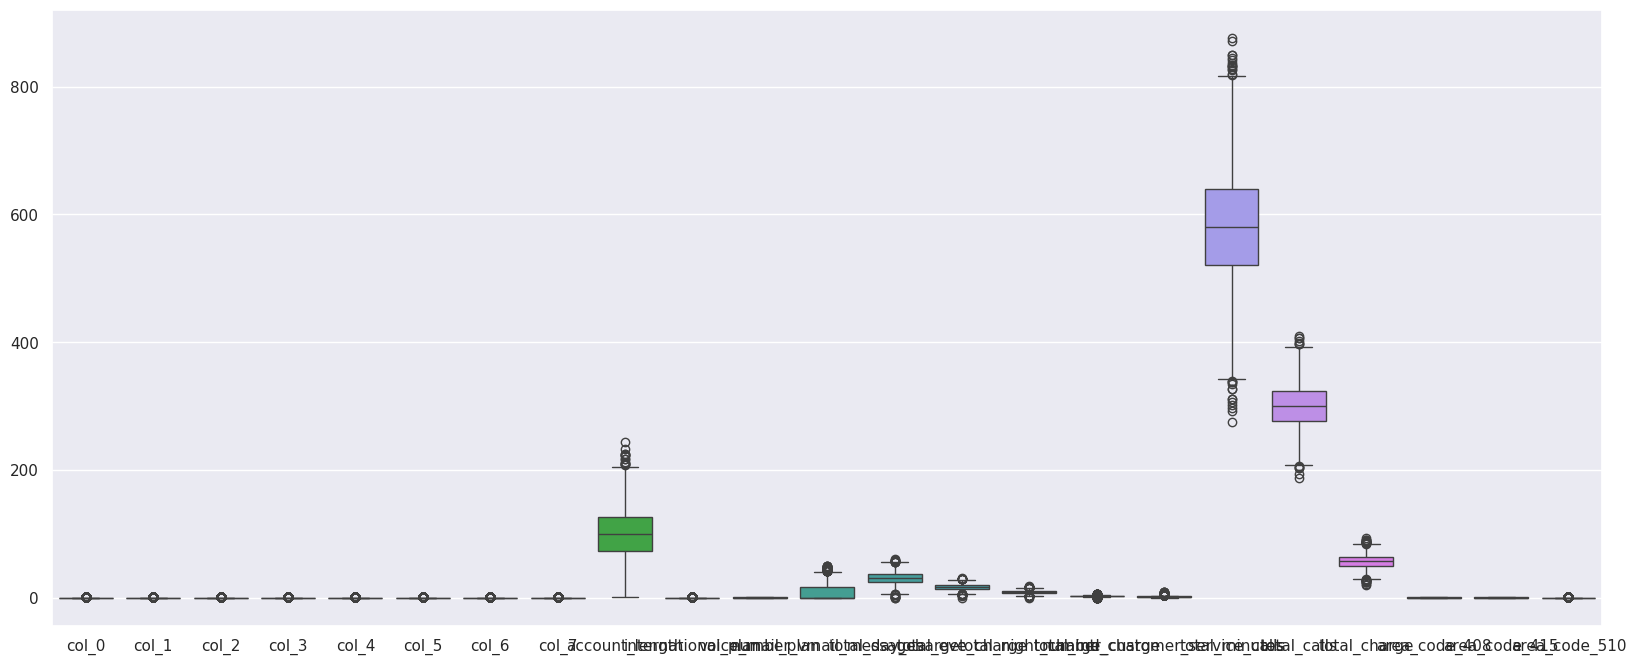

In [ ]:
#before standardization
sns.boxplot(data=X_train);

In [ ]:
normal_distributed = ['account_length',
                      'total_minutes',
                      'total_calls',
                      'total_day_charge',
                      'total_eve_charge',
                      'total_night_charge',
                      'total_intl_charge']

In [ ]:
scaler = StandardScaler()

X_train[normal_distributed] = scaler.fit_transform(X_train[normal_distributed])
X_test[normal_distributed] = scaler.fit_transform(X_test[normal_distributed])

In [ ]:
mms = MinMaxScaler()

X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

After going through the last transformations, The datasets need to be reset with their respective type as DataFrame, and Columns names

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
print(type(X_train))
print(type(X_test))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
cols = ['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_charge', 'total_eve_charge',
       'total_night_charge', 'total_intl_charge',
       'number_customer_service_calls', 'total_minutes', 'total_calls',
       'total_charge', 'area_code_408', 'area_code_415', 'area_code_510']
X_train.rename(columns=dict(enumerate(cols)), inplace=True)
X_test.rename(columns=dict(enumerate(cols)), inplace=True)

In [ ]:
print(X_train.columns)
print(X_test.columns)

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_charge', 'total_eve_charge',
       'total_night_charge', 'total_intl_charge',
       'number_customer_service_calls', 'total_minutes', 'total_calls',
       'total_charge', 'area_code_408', 'area_code_415', 'area_code_510'],
      dtype='object')
Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_charge', 'total_eve_charge',
       'total_night_charge', 'total_intl_charge',
       'number_customer_service_calls', 'total_minutes', 'total_calls',
       'total_charge', 'area_code_408', 'area_code_415', 'area_code_510'],
      dtype='object')


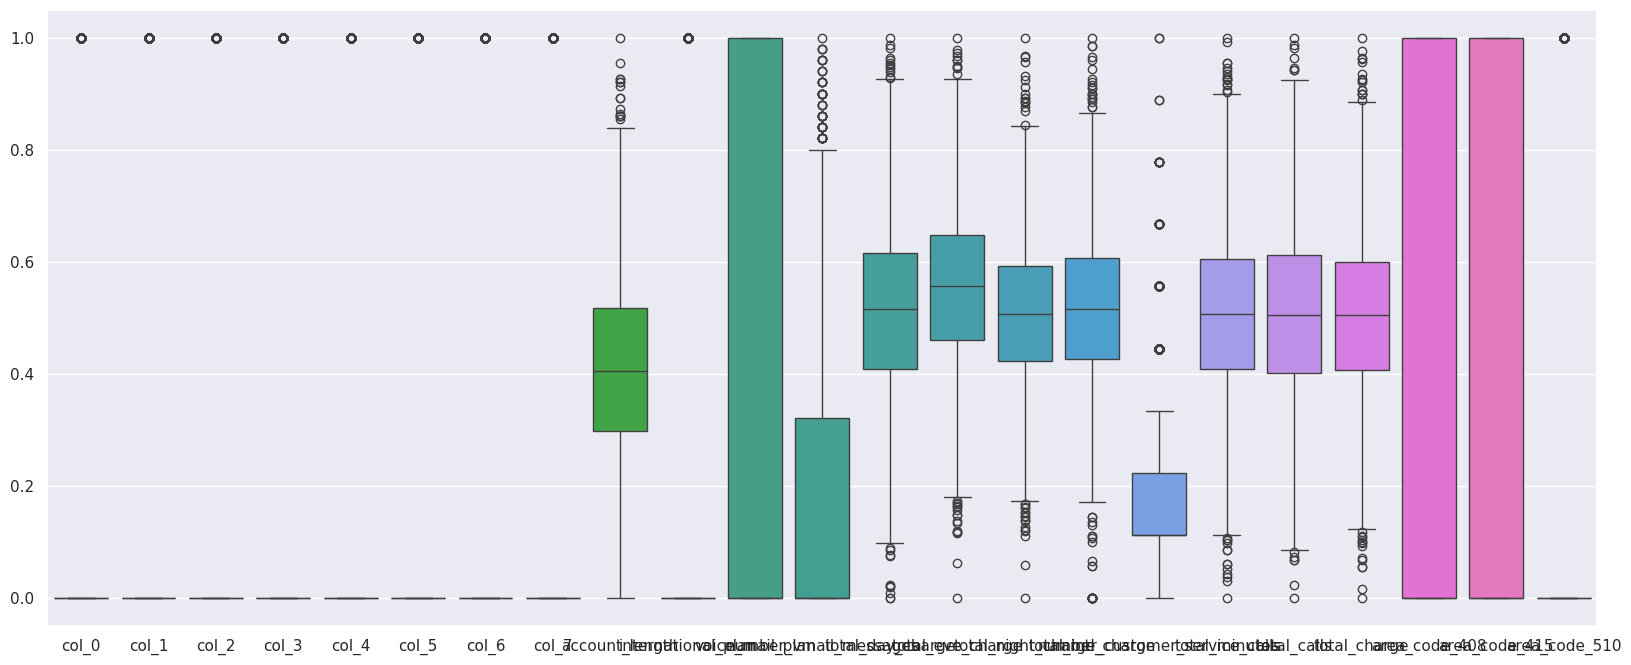

In [ ]:
#after standardization
sns.boxplot(data=X_train);

#5 ML model

##5.1 1st Application

###5.1.1 Baseline: Decision Tree Classifier

In [ ]:
#training
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)

#evaluating
accuracy_dt = accuracy(y_test, dt_predictions)
precision_dt = precision_score(y_test, dt_predictions)
recall_dt = recall_score(y_test, dt_predictions)

#printing performance
print("Baseline: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)

Baseline: Decision Tree Classifier Metrics:
Accuracy: 0.82
Precision: 0.42028985507246375
Recall: 0.725


###5.1.2 Baseline: Random Forest Classifier

In [ ]:
#training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

#evaluating
accuracy_rf = accuracy(y_test, rf_predictions)
precision_rf = precision_score(y_test, rf_predictions)
recall_rf = recall_score(y_test, rf_predictions)

#printing
print("Baseline: Random Forest Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)

Baseline: Random Forest Metrics:
Accuracy: 0.866
Precision: 0.5189873417721519
Recall: 0.6833333333333333


###5.1.3 Baseline: Logistic Regression

In [ ]:
#Training
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
lr_predictions = lr_classifier.predict(X_test)

#Evaluating
accuracy_lr = accuracy(y_test, lr_predictions)
precision_lr = precision_score(y_test, lr_predictions)
recall_lr = recall_score(y_test, lr_predictions)

#Printing
print("Baseline: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)

Baseline: Logistic Regression Metrics:
Accuracy: 0.854
Precision: 0.47560975609756095
Recall: 0.325


###5.1.4 Baseline: SVM

In [ ]:
#Training
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

#Evaluating
accuracy_svm = accuracy(y_test, svm_predictions)
precision_svm = precision_score(y_test, svm_predictions)
recall_svm = recall_score(y_test, svm_predictions)

#Printing
print("Baseline: SVM Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)

Baseline: SVM Metrics:
Accuracy: 0.885
Precision: 0.7291666666666666
Recall: 0.2916666666666667


###5.1.5 Baseline: LightGBM

In [ ]:
#Training
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train, y_train)
lgb_predictions = lgb_classifier.predict(X_test)

#Evaluating
accuracy_lgb = accuracy(y_test, lgb_predictions)
precision_lgb = precision_score(y_test, lgb_predictions)
recall_lgb = recall_score(y_test, lgb_predictions)

#Printing
print("Baseline: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb)
print("Precision:", precision_lgb)
print("Recall:", recall_lgb)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
Baseline: LightGBM Metrics:
Accuracy: 0.865
Precision: 0.5151515151515151
Recall: 0.7083333333333334


###5.1.6 Baseline (1st test) Results:

As the set main metric in this project is Accuracy, as previously discussed, we'll rank the algorithms and its performances based on such metrics:

In [ ]:
#creating a summary table of the baseline results
baseline_tab = [['Model', 'Accuracy', 'Precision',  'Recall'],
      ['Decision Tree', accuracy_dt, precision_dt, recall_dt],
      ['Random Forest', accuracy_rf, precision_rf, recall_rf],
      ['Log Regression', accuracy_lr, precision_lr, recall_lr],
      ['SVM', accuracy_svm, precision_svm, recall_svm],
      ['LightGBM', accuracy_lgb, precision_lgb, recall_lgb]]

print(tabulate(baseline_tab, headers='firstrow'))

#dataframe to rank Baseline performances
baseline_dt = pd.DataFrame({'Model Name':'Decision Tree','Accuracy':accuracy_dt},index=[0])
baseline_rf = pd.DataFrame({'Model Name':'Random Forest','Accuracy':accuracy_rf},index=[0])
baseline_lr = pd.DataFrame({'Model Name':'Log Regression','Accuracy':accuracy_lr},index=[0])
baseline_svm = pd.DataFrame({'Model Name':'SVM','Accuracy':accuracy_svm},index=[0])
baseline_lgb = pd.DataFrame({'Model Name':'LightGBM','Accuracy':accuracy_lgb},index=[0])

baseline_result = pd.concat([baseline_dt, baseline_rf, baseline_lr, baseline_svm, baseline_lgb])
baseline_result = baseline_result.sort_values('Accuracy', ascending=False)
baseline_result

Model             Accuracy    Precision    Recall
--------------  ----------  -----------  --------
Decision Tree        0.82      0.42029   0.725
Random Forest        0.866     0.518987  0.683333
Log Regression       0.854     0.47561   0.325
SVM                  0.885     0.729167  0.291667
LightGBM             0.865     0.515152  0.708333


,Model Name,Accuracy
0,SVM,0.885
0,Random Forest,0.866
0,LightGBM,0.865
0,Log Regression,0.854
0,Decision Tree,0.820


##5.2 Application after treating outliers

###5.2.1 Treating outliers

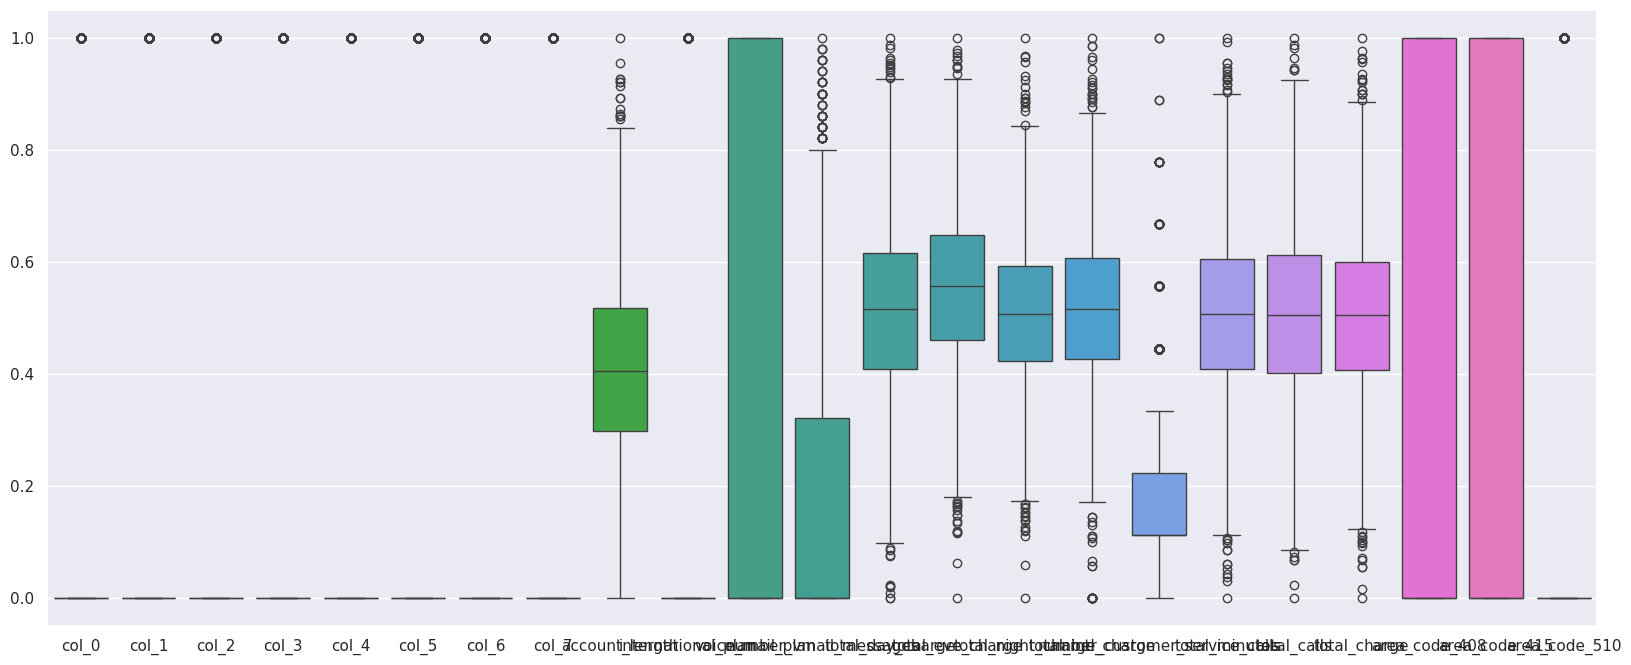

In [ ]:
#before treating outliers
sns.boxplot(data=X_train);

One good and easy technique to deal with outliers is using [Robust Scaler.](https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/)

To perform the next stage, will be copying the original datasets

In [ ]:
df1_train = X_train.copy()
df1_test = X_test.copy()

# perform a robust scaler transform of the dataset
rs = RobustScaler()
df1_train = rs.fit_transform(df1_train)
df1_test = rs.fit_transform(df1_test)

We'll also test [log transformation](https://towardsdatascience.com/dont-throw-away-your-outliers-c37e1ab0ce19)

In [ ]:
df2_train = X_train.copy()
df2_test = X_test.copy()

df2_train = np.log1p(df2_train)
df2_test = np.log1p(df2_test)

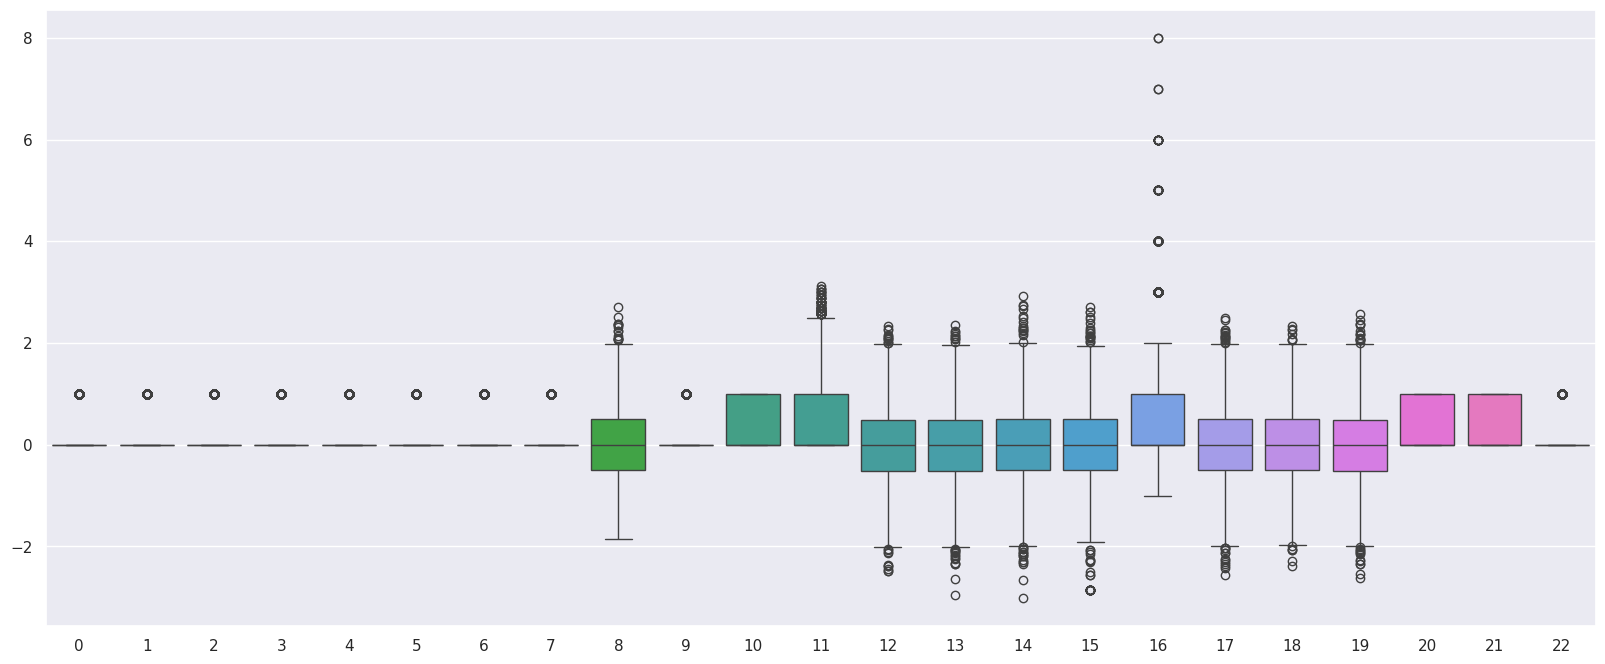

In [ ]:
#after encoding
sns.boxplot(data=df1_train);

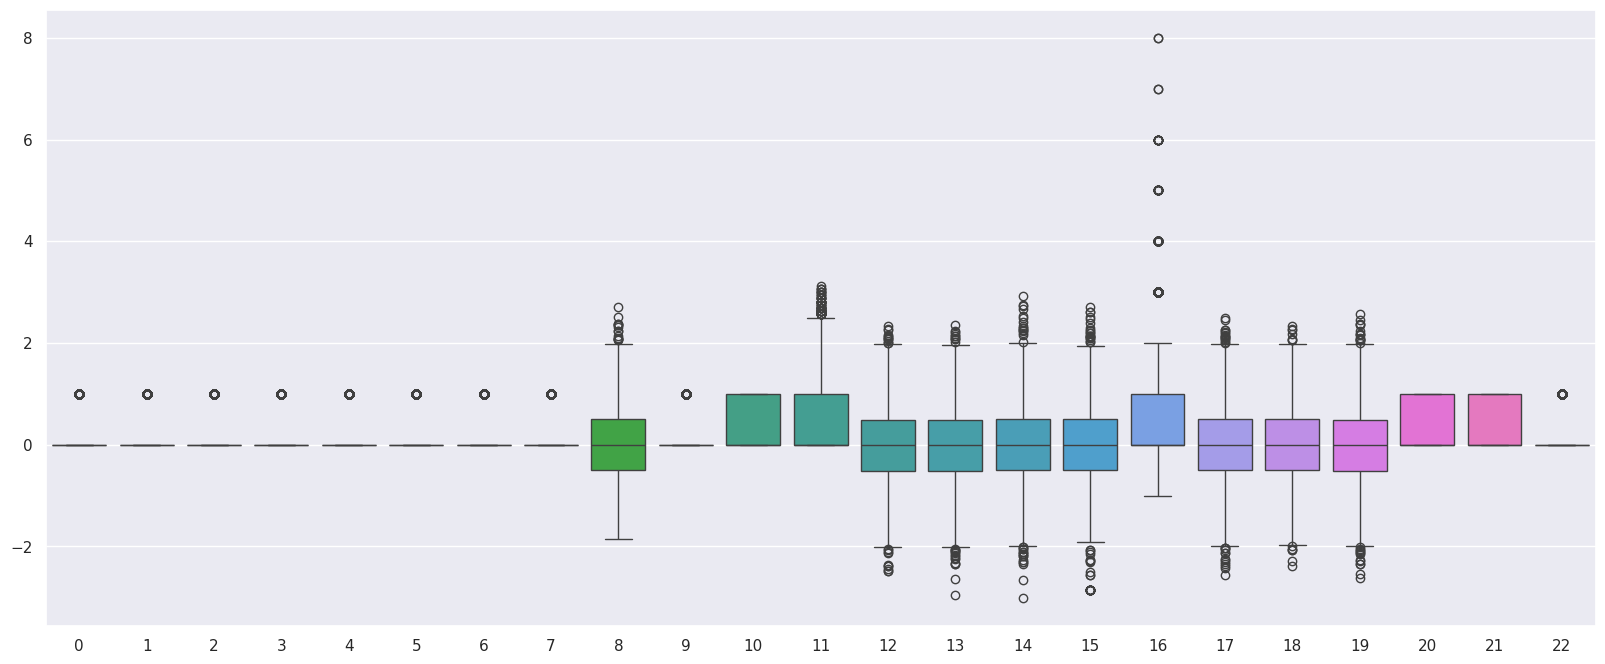

In [ ]:
#after log transformation
sns.boxplot(data=df1_train);

###5.2.2 Outliers: Decision Tree

In [ ]:
#training
dt1_classifier = DecisionTreeClassifier()
dt1_classifier.fit(df1_train, y_train)
dt1_predictions = dt_classifier.predict(df1_test)

#evaluating
accuracy_dt1 = accuracy(y_test, dt1_predictions)
precision_dt1 = precision_score(y_test, dt1_predictions)
recall_dt1 = recall_score(y_test, dt1_predictions)

#printing performance
print("Outliers: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt1)
print("Precision:", precision_dt1)
print("Recall:", recall_dt1)

Outliers: Decision Tree Classifier Metrics:
Accuracy: 0.514
Precision: 0.14004914004914004
Recall: 0.475


In [ ]:
#training
dt2_classifier = DecisionTreeClassifier()
dt2_classifier.fit(df2_train, y_train)
dt2_predictions = dt_classifier.predict(df2_test)

#evaluating
accuracy_dt2 = accuracy(y_test, dt2_predictions)
precision_dt2 = precision_score(y_test, dt2_predictions)
recall_dt2 = recall_score(y_test, dt2_predictions)

#printing performance
print("Outliers: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt2)
print("Precision:", precision_dt2)
print("Recall:", recall_dt2)

Outliers: Decision Tree Classifier Metrics:
Accuracy: 0.86
Precision: 0.5070422535211268
Recall: 0.3


The log transformation increased the performance of the decision Tree Classifier

###5.2.3 Outliers: Random Forest

In [ ]:
#training
rf1_classifier = RandomForestClassifier()
rf1_classifier.fit(df1_train, y_train)
rf1_predictions = rf_classifier.predict(df1_test)

#evaluating
accuracy_rf1 = accuracy(y_test, rf1_predictions)
precision_rf1 = precision_score(y_test, rf1_predictions)
recall_rf1 = recall_score(y_test, rf1_predictions)

#printing
print("Outliers: Random Forest Metrics:")
print("Accuracy:", accuracy_rf1)
print("Precision:", precision_rf1)
print("Recall:", recall_rf1)

Outliers: Random Forest Metrics:
Accuracy: 0.647
Precision: 0.2619047619047619
Recall: 0.825


In [ ]:
#training
rf2_classifier = RandomForestClassifier()
rf1_classifier.fit(df2_train, y_train)
rf2_predictions = rf_classifier.predict(df2_test)

#evaluating
accuracy_rf2 = accuracy(y_test, rf2_predictions)
precision_rf2 = precision_score(y_test, rf2_predictions)
recall_rf2 = recall_score(y_test, rf2_predictions)

#printing
print("Outliers: Random Forest Metrics:")
print("Accuracy:", accuracy_rf2)
print("Precision:", precision_rf2)
print("Recall:", recall_rf2)

Outliers: Random Forest Metrics:
Accuracy: 0.875
Precision: 0.6590909090909091
Recall: 0.24166666666666667


Log transformation also increased Random Forest Classifier performance

###5.2.4 Outliers: Logistic Regression

In [ ]:
#Training
lr1_classifier = LogisticRegression()
lr1_classifier.fit(df1_train, y_train)
lr1_predictions = lr1_classifier.predict(df1_test)

#Evaluating
accuracy_lr1 = accuracy(y_test, lr1_predictions)
precision_lr1 = precision_score(y_test, lr1_predictions)
recall_lr1 = recall_score(y_test, lr1_predictions)

#Printing
print("Outliers: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr1)
print("Precision:", precision_lr1)
print("Recall:", recall_lr1)

Outliers: Logistic Regression Metrics:
Accuracy: 0.848
Precision: 0.40816326530612246
Recall: 0.16666666666666666


In [ ]:
#Training
lr2_classifier = LogisticRegression()
lr2_classifier.fit(df2_train, y_train)
lr2_predictions = lr2_classifier.predict(df2_test)

#Evaluating
accuracy_lr2 = accuracy(y_test, lr2_predictions)
precision_lr2 = precision_score(y_test, lr2_predictions)
recall_lr2 = recall_score(y_test, lr2_predictions)

#Printing
print("Outliers: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr2)
print("Precision:", precision_lr2)
print("Recall:", recall_lr2)

Outliers: Logistic Regression Metrics:
Accuracy: 0.847
Precision: 0.41935483870967744
Recall: 0.21666666666666667


###5.2.5 Outiers: SVM

In [ ]:
#Training
svm1_classifier = SVC()
svm1_classifier.fit(df1_train, y_train)
svm1_predictions = svm1_classifier.predict(df1_test)

#Evaluating
accuracy_svm1 = accuracy(y_test, svm1_predictions)
precision_svm1 = precision_score(y_test, svm1_predictions)
recall_svm1 = recall_score(y_test, svm1_predictions)

#Printing
print("Outliers: SVM Metrics:")
print("Accuracy:", accuracy_svm1)
print("Precision:", precision_svm1)
print("Recall:", recall_svm1)

Outliers: SVM Metrics:
Accuracy: 0.936
Precision: 0.9852941176470589
Recall: 0.5583333333333333


In [ ]:
#Training
svm2_classifier = SVC()
svm2_classifier.fit(df2_train, y_train)
svm2_predictions = svm2_classifier.predict(df2_test)

#Evaluating
accuracy_svm2 = accuracy(y_test, svm2_predictions)
precision_svm2 = precision_score(y_test, svm2_predictions)
recall_svm2 = recall_score(y_test, svm2_predictions)

#Printing
print("Outliers: SVM Metrics:")
print("Accuracy:", accuracy_svm2)
print("Precision:", precision_svm2)
print("Recall:", recall_svm2)

Outliers: SVM Metrics:
Accuracy: 0.869
Precision: 0.6363636363636364
Recall: 0.175


Now RobustScaler improved very much the performance

###5.2.6 Outliers: LightGBM

In [ ]:
#Training
lgb1_classifier = lgb.LGBMClassifier()
lgb1_classifier.fit(df1_train, y_train)
lgb1_predictions = lgb1_classifier.predict(df1_test)

#Evaluating
accuracy_lgb1 = accuracy(y_test, lgb1_predictions)
precision_lgb1 = precision_score(y_test, lgb1_predictions)
recall_lgb1 = recall_score(y_test, lgb1_predictions)

#Printing
print("Outliers: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb1)
print("Precision:", precision_lgb1)
print("Recall:", recall_lgb1)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
Outliers: LightGBM Metrics:
Accuracy: 0.949
Precision: 0.9230769230769231
Recall: 0.7


In [ ]:
#Training
lgb2_classifier = lgb.LGBMClassifier()
lgb2_classifier.fit(df2_train, y_train)
lgb2_predictions = lgb2_classifier.predict(df2_test)

#Evaluating
accuracy_lgb2 = accuracy(y_test, lgb2_predictions)
precision_lgb2 = precision_score(y_test, lgb2_predictions)
recall_lgb2 = recall_score(y_test, lgb2_predictions)

#Printing
print("Outliers: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb2)
print("Precision:", precision_lgb2)
print("Recall:", recall_lgb2)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
Outliers: LightGBM Metrics:
Accuracy: 0.866
Precision: 0.5182926829268293
Recall: 0.7083333333333334


###5.2.7 Results after outliers treatment

In [ ]:
#creating a summary table of the baseline results
outliers_tab = [['Model', 'Accuracy', 'Precision',  'Recall', 'Transformation'],
      ['Decision Tree', accuracy_dt2, precision_dt2, recall_dt2, 'Log Transformation'],
      ['Random Forest', accuracy_rf2, precision_rf2, recall_rf2, 'Log Transformation'],
      ['Log Regression', accuracy_lr1, precision_lr1, recall_lr1, 'Robust Scaler'],
      ['SVM', accuracy_svm1, precision_svm1, recall_svm1, 'Robust Scaler' ],
      ['LightGBM', accuracy_lgb1, precision_lgb1, recall_lgb1, 'Robust Scaler']]

print(tabulate(outliers_tab, headers='firstrow'))

#dataframe to rank Baseline performances
outlier_dt = pd.DataFrame({'Model Name':'Decision Tree','Accuracy':accuracy_dt2, 'Method': 'Log'},index=[0])
outlier_rf = pd.DataFrame({'Model Name':'Random Forest','Accuracy':accuracy_rf2, 'Method': 'Log'},index=[0])
outlier_lr = pd.DataFrame({'Model Name':'Log Regression','Accuracy':accuracy_lr1, 'Method': 'RS'},index=[0])
outlier_svm = pd.DataFrame({'Model Name':'SVM','Accuracy':accuracy_svm1, 'Method': 'RS'},index=[0])
outlier_lgb = pd.DataFrame({'Model Name':'LightGBM','Accuracy':accuracy_lgb1, 'Method': 'RS'},index=[0])

outlier_result = pd.concat([outlier_dt, outlier_rf, outlier_lr, outlier_svm, outlier_lgb])
outlier_result = outlier_result.sort_values('Accuracy', ascending=False)
outlier_result

Model             Accuracy    Precision    Recall  Transformation
--------------  ----------  -----------  --------  ------------------
Decision Tree        0.86      0.507042  0.3       Log Transformation
Random Forest        0.875     0.659091  0.241667  Log Transformation
Log Regression       0.848     0.408163  0.166667  Robust Scaler
SVM                  0.936     0.985294  0.558333  Robust Scaler
LightGBM             0.949     0.923077  0.7       Robust Scaler


,Model Name,Accuracy,Method
0,LightGBM,0.949,RS
0,SVM,0.936,RS
0,Random Forest,0.875,Log
0,Decision Tree,0.860,Log
0,Log Regression,0.848,RS


##5.3 DISCARDED: Application after upsampling

###5.3.1 Creating samples

Before upsampling count of label 0 2922
Before upsampling count of label 1 478


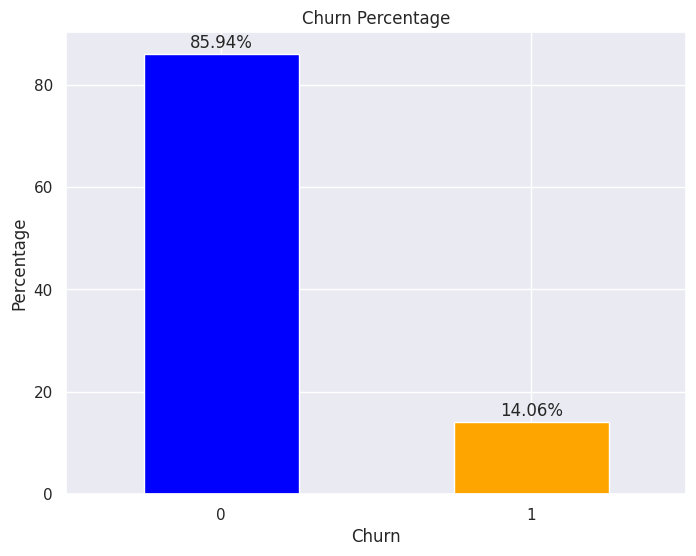

In [ ]:
print('Before upsampling count of label 0 {}'.format(sum(y_train==0)))
print('Before upsampling count of label 1 {}'.format(sum(y_train==1)))

#computing the percentage of values
y_train_counts = y_train.value_counts(normalize=True) * 100

#ploting the distribution of values in percentage
plt.figure(figsize=(8, 6))
y_train_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Churn Percentage')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
for i, v in enumerate(y_train_counts):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

plt.show()

In [ ]:
#creating copies
df3_train = X_train.copy()
df3_test = X_test.copy()
df3_train_y = y_train.copy()
df3_test_y = y_test.copy()


# Minority Over Sampling Technique
sm = SMOTE(sampling_strategy = 1, random_state=1)
df3_train, df3_train_y = sm.fit_resample(df3_train, df3_train_y.ravel())

In [ ]:
print('After upsampling count of label 0 {}'.format(sum(df3_train_y==0)))
print('After upsampling count of label 1 {}'.format(sum(df3_train_y==1)))

After upsampling count of label 0 2922
After upsampling count of label 1 2922


###5.3.2 Upsampling: Decision Tree Classifier

In [ ]:
#training
dt3_classifier = DecisionTreeClassifier()
dt3_classifier.fit(df3_train, df3_train_y)
dt3_predictions = dt3_classifier.predict(df3_test)

#evaluating
accuracy_dt3 = accuracy(df3_test_y, dt3_predictions)
precision_dt3 = precision_score(df3_test_y, dt3_predictions)
recall_dt3 = recall_score(df3_test_y, dt_predictions)

#printing performance
print("Upsampling: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt3)
print("Precision:", precision_dt3)
print("Recall:", recall_dt3)

Upsampling: Decision Tree Classifier Metrics:
Accuracy: 0.3905882352941176
Precision: 0.16722408026755853
Recall: 0.725


###5.3.3 Upsampling: Random Forest Classifier

In [ ]:
#training
rf3_classifier = RandomForestClassifier()
rf3_classifier.fit(df3_train, df3_train_y)
rf3_predictions = rf3_classifier.predict(df3_test)

#evaluating
accuracy_rf3 = accuracy(df3_test_y, rf3_predictions)
precision_rf3 = precision_score(df3_test_y, rf3_predictions)
recall_rf3 = recall_score(df3_test_y, rf3_predictions)

#printing
print("upsampling: Random Forest Metrics:")
print("Accuracy:", accuracy_rf3)
print("Precision:", precision_rf3)
print("Recall:", recall_rf3)

upsampling: Random Forest Metrics:
Accuracy: 0.8105882352941176
Precision: 0.41125541125541126
Recall: 0.7916666666666666


###5.3.4 Upsampling: Logistic Regression

In [ ]:
#Training
lr3_classifier = LogisticRegression()
lr3_classifier.fit(df3_train, df3_train_y)
lr3_predictions = lr3_classifier.predict(df3_test)

#Evaluating
accuracy_lr3 = accuracy(df3_test_y, lr3_predictions)
precision_lr3 = precision_score(df3_test_y, lr3_predictions)
recall_lr3 = recall_score(df3_test_y, lr3_predictions)

#Printing
print("Upsampling: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr3)
print("Precision:", precision_lr3)
print("Recall:", recall_lr3)

Upsampling: Logistic Regression Metrics:
Accuracy: 0.6788235294117647
Precision: 0.27953890489913547
Recall: 0.8083333333333333


###5.3.5 Upsampling: SVM

In [ ]:
#Training
svm3_classifier = SVC()
svm3_classifier.fit(df3_train, df3_train_y)
svm3_predictions = svm3_classifier.predict(df3_test)

#Evaluating
accuracy_svm3 = accuracy(df3_test_y, svm3_predictions)
precision_svm3 = precision_score(df3_test_y, svm3_predictions)
recall_svm3 = recall_score(df3_test_y, svm3_predictions)

#Printing
print("Upsampling: SVM Metrics:")
print("Accuracy:", accuracy_svm3)
print("Precision:", precision_svm3)
print("Recall:", recall_svm3)

Upsampling: SVM Metrics:
Accuracy: 0.7447058823529412
Precision: 0.3333333333333333
Recall: 0.8083333333333333


###5.3.6 Upsampling: LightGBM

In [ ]:
#Training
lgb3_classifier = lgb.LGBMClassifier()
lgb3_classifier.fit(df3_train, df3_train_y)
lgb3_predictions = lgb3_classifier.predict(df3_test)

#Evaluating
accuracy_lgb3 = accuracy(df3_test_y, lgb3_predictions)
precision_lgb3 = precision_score(df3_test_y, lgb3_predictions)
recall_lgb3 = recall_score(df3_test_y, lgb3_predictions)

#Printing
print("Upsampling: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb3)
print("Precision:", precision_lgb3)
print("Recall:", recall_lgb3)

[LightGBM] [Info] Number of positive: 2922, number of negative: 2922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2708
[LightGBM] [Info] Number of data points in the train set: 5844, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Upsampling: LightGBM Metrics:
Accuracy: 0.3635294117647059
Precision: 0.17160686427457097
Recall: 0.9166666666666666


###5.3.7 Results after upsampling

In [ ]:
#creating a summary table of the baseline results
upsampling_tab = [['Model', 'Accuracy', 'Precision',  'Recall'],
      ['Decision Tree', accuracy_dt3, precision_dt3, recall_dt3],
      ['Random Forest', accuracy_rf3, precision_rf3, recall_rf3],
      ['Log Regression', accuracy_lr3, precision_lr3, recall_lr3],
      ['SVM', accuracy_svm3, precision_svm3, recall_svm3],
      ['LightGBM', accuracy_lgb3, precision_lgb3, recall_lgb3]]

print(tabulate(upsampling_tab, headers='firstrow'))

#dataframe to rank Baseline performances
upsampling_dt = pd.DataFrame({'Model Name':'Decision Tree','Accuracy':accuracy_dt3},index=[0])
upsampling_rf = pd.DataFrame({'Model Name':'Random Forest','Accuracy':accuracy_rf3},index=[0])
upsampling_lr = pd.DataFrame({'Model Name':'Log Regression','Accuracy':accuracy_lr3},index=[0])
upsampling_svm = pd.DataFrame({'Model Name':'SVM','Accuracy':accuracy_svm3},index=[0])
upsampling_lgb = pd.DataFrame({'Model Name':'LightGBM','Accuracy':accuracy_lgb3},index=[0])

upsampling_result = pd.concat([upsampling_dt, upsampling_rf, upsampling_lr, upsampling_svm, upsampling_lgb])
upsampling_result = upsampling_result.sort_values('Accuracy', ascending=False)
upsampling_result

Model             Accuracy    Precision    Recall
--------------  ----------  -----------  --------
Decision Tree     0.390588     0.167224  0.725
Random Forest     0.810588     0.411255  0.791667
Log Regression    0.678824     0.279539  0.808333
SVM               0.744706     0.333333  0.808333
LightGBM          0.363529     0.171607  0.916667


,Model Name,Accuracy
0,Random Forest,0.810588
0,SVM,0.744706
0,Log Regression,0.678824
0,Decision Tree,0.390588
0,LightGBM,0.363529


**Upsampling** doesn't look like a helpful technique for this case, so then **we will discard it**

##5.4 Application after feature selection

###5.4.1 Feature Selection: Mutual_Info

In [ ]:
mi_scores = mutual_info_regression(X_train, y_train)

scores_mi = pd.DataFrame({
    'Feature': pd.DataFrame(X_train).columns,
    'MI-Score': mi_scores})

scores_mi = scores_mi[['Feature', 'MI-Score']].sort_values(by='MI-Score', ascending=False)
scores_mi

,Feature,MI-Score
19,total_charge,0.096923
12,total_day_charge,0.060891
16,number_customer_service_calls,0.052548
17,total_minutes,0.050327
9,international_plan,0.037436
18,total_calls,0.024927
21,area_code_415,0.017217
8,account_length,0.009264
15,total_intl_charge,0.008303
13,total_eve_charge,0.005123


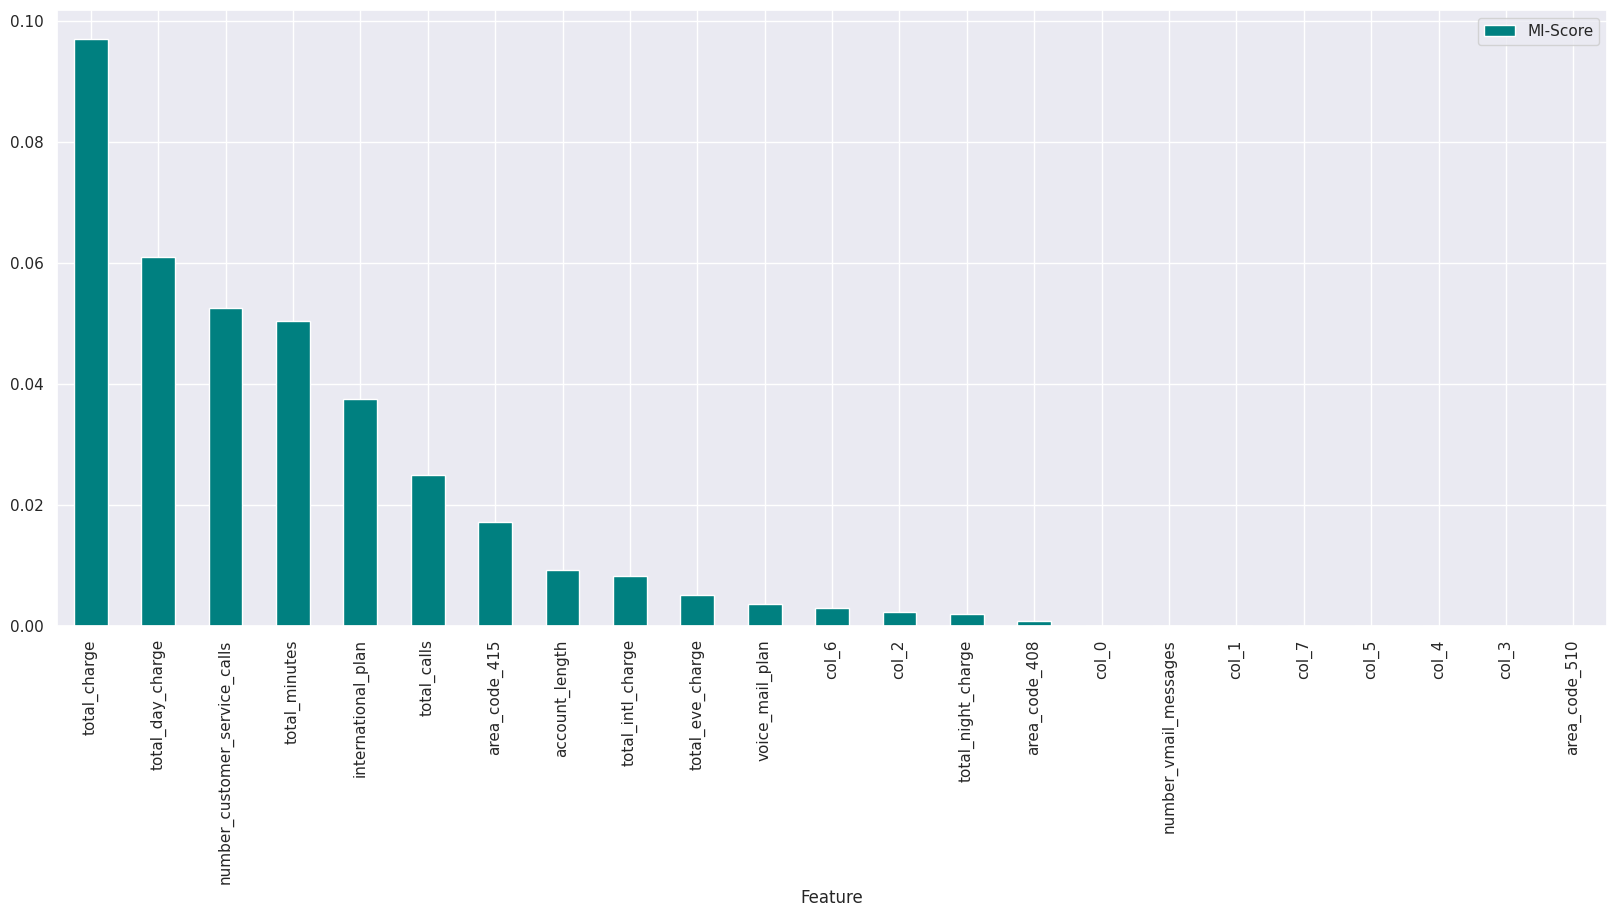

In [ ]:
scores_mi.set_index('Feature', inplace=True)
scores_mi.plot.bar(color = 'teal');

###5.4.2 Feature Selection: Tree-Based

In [ ]:
importances = rf_classifier.feature_importances_
important_features = pd.DataFrame({"Features":X_train.columns, "Importances": importances})
important_features = important_features.sort_values("Importances", ascending=False)
important_features

,Features,Importances
19,total_charge,0.230138
16,number_customer_service_calls,0.126555
17,total_minutes,0.120065
12,total_day_charge,0.115327
9,international_plan,0.070341
15,total_intl_charge,0.059713
13,total_eve_charge,0.046561
14,total_night_charge,0.044332
8,account_length,0.040353
18,total_calls,0.036449


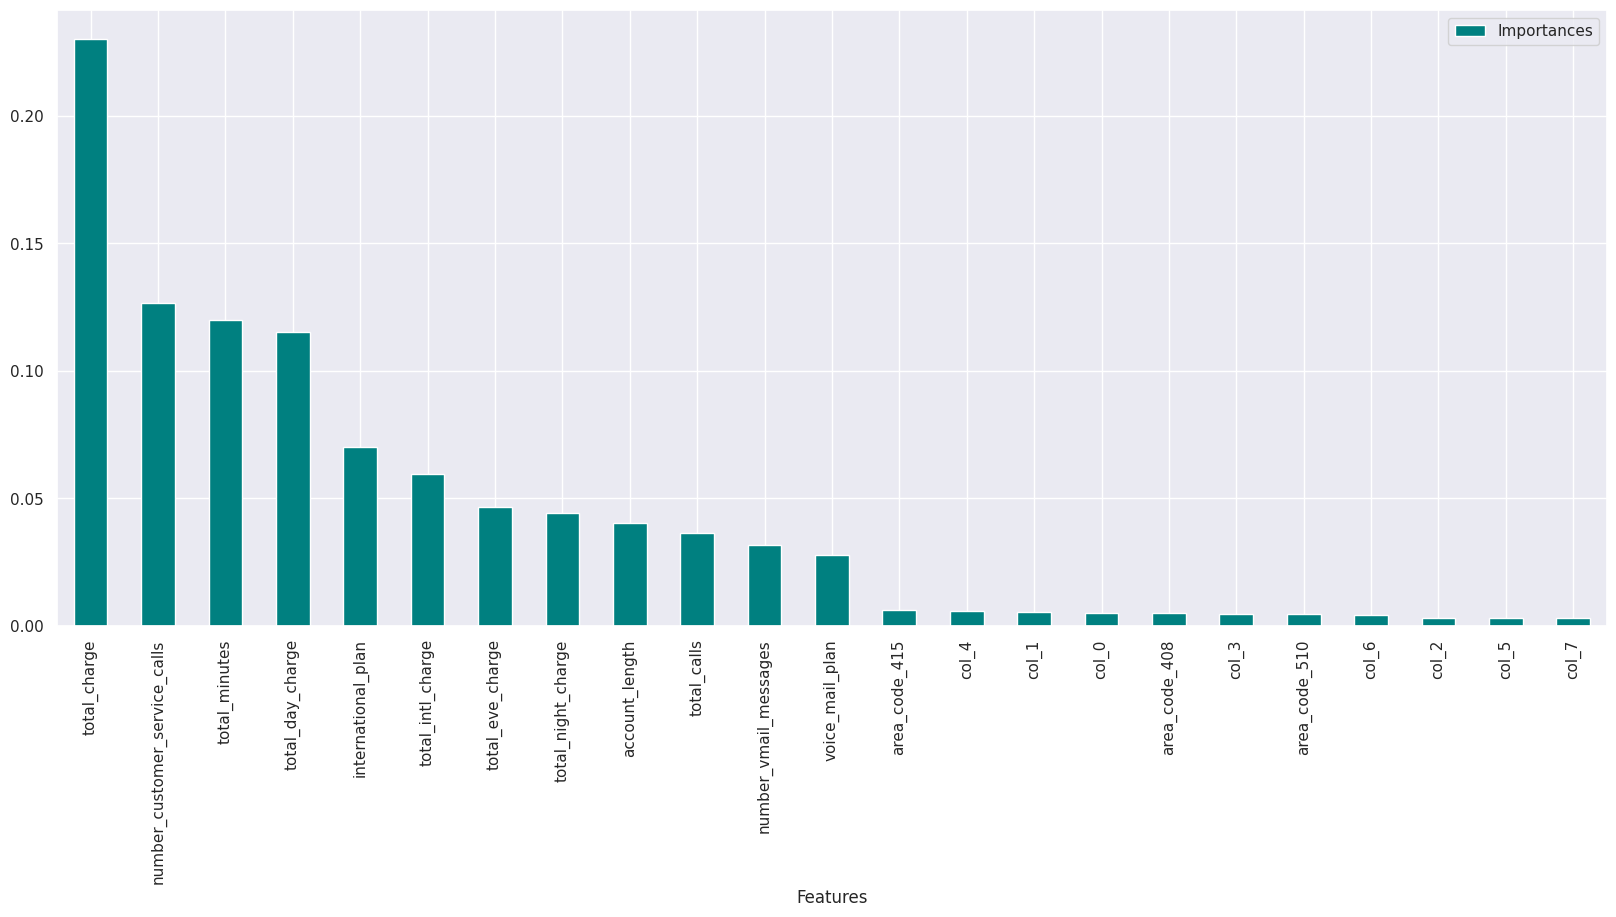

In [ ]:
important_features.set_index('Features', inplace=True)
important_features.plot.bar(color = 'teal');

###5.4.3 Feature Selection: RFE

In [ ]:
rfe = RFE(lr_classifier, n_features_to_select=4)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("RFE Selected Features:", selected_features)

RFE Selected Features: Index(['international_plan', 'total_day_charge',
       'number_customer_service_calls', 'total_charge'],
      dtype='object')


In [ ]:
rfe = RFE(lr_classifier, n_features_to_select=6)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("RFE Selected Features:", selected_features)

RFE Selected Features: Index(['international_plan', 'total_day_charge', 'total_intl_charge',
       'number_customer_service_calls', 'total_minutes', 'total_charge'],
      dtype='object')


In [ ]:
rfe = RFE(lr_classifier, n_features_to_select=9)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("RFE Selected Features:", selected_features)

RFE Selected Features: Index(['international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_charge', 'total_eve_charge', 'total_intl_charge',
       'number_customer_service_calls', 'total_minutes', 'total_charge'],
      dtype='object')


###5.4.4 Feature Selection Results

According to the 3 methods of selection and also considering the EDA (in the case of International plan for example) these are the best 10 features sorted:

1.   **'total_charge'**
2.   ***'number_customer_service_calls'***
3.   ***'total_day_charge'***
4.   **'total_minutes'**
5.   ***'international_plan'***
6.   'total_intl_charge'
7.   'total_eve_charge'
8.   'total_calls'
9.   'account_length'
10.   'voice_mail_plan'


The ones in **bold** are the ones that all selectors unanimously considered as relevant. While the ones in *italic* are the ones that we've particularly checked at EDA stage.

The international plan was proved to impact postively if a customer is a churn, while the number of voice messages, although it has a weak correlation, it was proved not to be determinent if a customer tends to be a churn for that.





---



Also, we know that some of these features doesn't add much information due to the fact they have similar information. For example:



*   'total_charge' contains 'total_day_charge' and 'total_eve_charge'

So, we will make **a list of only 8 features **that actually add information, **excluding 'total_day_charge' and 'total_eve_charge'**





---



Hence, we'll do **2 tests**, 1 considering only the **top 5 features** and another considering the **list of 8 features**

In [ ]:
top_5 = ['total_charge',
         'number_customer_service_calls',
         'total_day_charge',
         'total_minutes',
         'international_plan']

features_8 = ['total_charge',
         'number_customer_service_calls',
         'total_minutes',
         'international_plan',
         'total_intl_charge',
              'total_calls',
              'account_length',
              'voice_mail_plan']

In [ ]:
#filtering the features of interest
df4_train = X_train[top_5]
df4_test = X_test[top_5]
df5_train = X_train[features_8]
df5_test = X_test[features_8]

###5.4.5 Feature Selection: Decision Tree Classifier

In [ ]:
#training
dt4_classifier = DecisionTreeClassifier()
dt4_classifier.fit(df4_train, y_train)
dt4_predictions = dt4_classifier.predict(df4_test)

#evaluating
accuracy_dt4 = accuracy(y_test, dt4_predictions)
precision_dt4 = precision_score(y_test, dt4_predictions)
recall_dt4 = recall_score(y_test, dt4_predictions)

#printing performance
print("Feature Selection: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt4)
print("Precision:", precision_dt4)
print("Recall:", recall_dt4)

Feature Selection: Decision Tree Classifier Metrics:
Accuracy: 0.786
Precision: 0.35096153846153844
Recall: 0.6083333333333333


In [ ]:
#training
dt5_classifier = DecisionTreeClassifier()
dt5_classifier.fit(df5_train, y_train)
dt5_predictions = dt5_classifier.predict(df5_test)

#evaluating
accuracy_dt5 = accuracy(y_test, dt5_predictions)
precision_dt5 = precision_score(y_test, dt5_predictions)
recall_dt5 = recall_score(y_test, dt5_predictions)

#printing performance
print("Feature Selection: Decision Tree Classifier Metrics:")
print("Accuracy:", accuracy_dt5)
print("Precision:", precision_dt5)
print("Recall:", recall_dt5)

Feature Selection: Decision Tree Classifier Metrics:
Accuracy: 0.813
Precision: 0.40930232558139534
Recall: 0.7333333333333333


###5.4.6 Feature Selection: Random Forest Classifier

In [ ]:
#training
rf4_classifier = RandomForestClassifier()
rf4_classifier.fit(df4_train, y_train)
rf4_predictions = rf4_classifier.predict(df4_test)

#evaluating
accuracy_rf4 = accuracy(y_test, rf4_predictions)
precision_rf4 = precision_score(y_test, rf4_predictions)
recall_rf4 = recall_score(y_test, rf4_predictions)

#printing
print("Feature Selection: Random Forest Metrics:")
print("Accuracy:", accuracy_rf4)
print("Precision:", precision_rf4)
print("Recall:", recall_rf4)

Feature Selection: Random Forest Metrics:
Accuracy: 0.827
Precision: 0.42702702702702705
Recall: 0.6583333333333333


In [ ]:
#training
rf5_classifier = RandomForestClassifier()
rf5_classifier.fit(df5_train, y_train)
rf5_predictions = rf5_classifier.predict(df5_test)

#evaluating
accuracy_rf5 = accuracy(y_test, rf5_predictions)
precision_rf5 = precision_score(y_test, rf5_predictions)
recall_rf5 = recall_score(y_test, rf5_predictions)

#printing
print("Feature Selection: Random Forest Metrics:")
print("Accuracy:", accuracy_rf5)
print("Precision:", precision_rf5)
print("Recall:", recall_rf5)

Feature Selection: Random Forest Metrics:
Accuracy: 0.862
Precision: 0.5088757396449705
Recall: 0.7166666666666667


###5.4.7 Feature Selection: Logistic Regression

In [ ]:
#Training
lr4_classifier = LogisticRegression()
lr4_classifier.fit(df4_train, y_train)
lr4_predictions = lr4_classifier.predict(df4_test)

#Evaluating
accuracy_lr4 = accuracy(y_test, lr4_predictions)
precision_lr4 = precision_score(y_test, lr4_predictions)
recall_lr4 = recall_score(y_test, lr4_predictions)

#Printing
print("Feature Selection: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr4)
print("Precision:", precision_lr4)
print("Recall:", recall_lr4)

Feature Selection: Logistic Regression Metrics:
Accuracy: 0.836
Precision: 0.3698630136986301
Recall: 0.225


In [ ]:
#Training
lr5_classifier = LogisticRegression()
lr5_classifier.fit(df5_train, y_train)
lr5_predictions = lr5_classifier.predict(df5_test)

#Evaluating
accuracy_lr5 = accuracy(y_test, lr5_predictions)
precision_lr5 = precision_score(y_test, lr5_predictions)
recall_lr5 = recall_score(y_test, lr5_predictions)

#Printing
print("Feature Selection: Logistic Regression Metrics:")
print("Accuracy:", accuracy_lr5)
print("Precision:", precision_lr5)
print("Recall:", recall_lr5)

Feature Selection: Logistic Regression Metrics:
Accuracy: 0.846
Precision: 0.43209876543209874
Recall: 0.2916666666666667


###5.4.8 Feature Selection: SVM

In [ ]:
#Training
svm4_classifier = SVC()
svm4_classifier.fit(df4_train, y_train)
svm4_predictions = svm4_classifier.predict(df4_test)

#Evaluating
accuracy_svm4 = accuracy(y_test, svm4_predictions)
precision_svm4 = precision_score(y_test, svm4_predictions)
recall_svm4 = recall_score(y_test, svm4_predictions)

#Printing
print("Feature Selection: SVM Metrics:")
print("Accuracy:", accuracy_svm4)
print("Precision:", precision_svm4)
print("Recall:", recall_svm4)

Feature Selection: SVM Metrics:
Accuracy: 0.912
Precision: 0.6991150442477876
Recall: 0.6583333333333333


In [ ]:
#Training
svm5_classifier = SVC()
svm5_classifier.fit(df5_train, y_train)
svm5_predictions = svm5_classifier.predict(df5_test)

#Evaluating
accuracy_svm5 = accuracy(y_test, svm5_predictions)
precision_svm5 = precision_score(y_test, svm5_predictions)
recall_svm5 = recall_score(y_test, svm5_predictions)

#Printing
print("Feature Selection: SVM Metrics:")
print("Accuracy:", accuracy_svm5)
print("Precision:", precision_svm5)
print("Recall:", recall_svm5)

Feature Selection: SVM Metrics:
Accuracy: 0.911
Precision: 0.6864406779661016
Recall: 0.675


###5.4.9 Feature Selection: LightGBM

In [ ]:
#Training
lgb4_classifier = lgb.LGBMClassifier()
lgb4_classifier.fit(df4_train, y_train)
lgb4_predictions = lgb4_classifier.predict(df4_test)

#Evaluating
accuracy_lgb4 = accuracy(y_test, lgb4_predictions)
precision_lgb4 = precision_score(y_test, lgb4_predictions)
recall_lgb4 = recall_score(y_test, lgb4_predictions)

#Printing
print("Feature Selection: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb4)
print("Precision:", precision_lgb4)
print("Recall:", recall_lgb4)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
Feature Selection: LightGBM Metrics:
Accuracy: 0.821
Precision: 0.41208791208791207
Recall: 0.625


In [ ]:
#Training
lgb5_classifier = lgb.LGBMClassifier()
lgb5_classifier.fit(df5_train, y_train)
lgb5_predictions = lgb5_classifier.predict(df5_test)

#Evaluating
accuracy_lgb5 = accuracy(y_test, lgb5_predictions)
precision_lgb5 = precision_score(y_test, lgb5_predictions)
recall_lgb5 = recall_score(y_test, lgb5_predictions)

#Printing
print("Feature Selection: LightGBM Metrics:")
print("Accuracy:", accuracy_lgb5)
print("Precision:", precision_lgb5)
print("Recall:", recall_lgb5)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
Feature Selection: LightGBM Metrics:
Accuracy: 0.856
Precision: 0.49404761904761907
Recall: 0.6916666666666667


###5.4.10 Results after Filtering main important features

In [ ]:
#creating a summary table of the results
fs_tab = [['Model', 'Accuracy', 'Precision',  'Recall', 'group_of_features'],
      ['Decision Tree', accuracy_dt5, precision_dt5, recall_dt5, 'features_6'],
      ['Random Forest', accuracy_rf5, precision_rf5, recall_rf5, 'features_6'],
      ['Log Regression', accuracy_lr5, precision_lr5, recall_lr5, 'features_6'],
      ['SVM', accuracy_svm5, precision_svm5, recall_svm5, 'features_6' ],
      ['LightGBM', accuracy_lgb5, precision_lgb5, recall_lgb5, 'features_6']]

print(tabulate(fs_tab, headers='firstrow'))

#dataframe to rank Baseline performances
fs_dt = pd.DataFrame({'Model Name':'Decision Tree','Accuracy':accuracy_dt5},index=[0])
fs_rf = pd.DataFrame({'Model Name':'Random Forest','Accuracy':accuracy_rf5},index=[0])
fs_lr = pd.DataFrame({'Model Name':'Log Regression','Accuracy':accuracy_lr5},index=[0])
fs_svm = pd.DataFrame({'Model Name':'SVM','Accuracy':accuracy_svm5},index=[0])
fs_lgb = pd.DataFrame({'Model Name':'LightGBM','Accuracy':accuracy_lgb5},index=[0])

fs_result = pd.concat([fs_dt, fs_rf, fs_lr, fs_svm, fs_lgb])
fs_result = fs_result.sort_values('Accuracy', ascending=False)
fs_result

Model             Accuracy    Precision    Recall  group_of_features
--------------  ----------  -----------  --------  -------------------
Decision Tree        0.813     0.409302  0.733333  features_6
Random Forest        0.862     0.508876  0.716667  features_6
Log Regression       0.846     0.432099  0.291667  features_6
SVM                  0.911     0.686441  0.675     features_6
LightGBM             0.856     0.494048  0.691667  features_6


,Model Name,Accuracy
0,SVM,0.911
0,Random Forest,0.862
0,LightGBM,0.856
0,Log Regression,0.846
0,Decision Tree,0.813


The list of 8 features seems to contribute slightly for the algorithms performances, and it definitely addresses a dimentionality issue

##5.5 Application after all treatments combined

###5.5.0 Observing performances so far

In [ ]:
print('Feature Selection')
print(fs_result, '\n')
print('outliers treated')
print(outlier_result, '\n')
print('Baseline')
print(baseline_result, '\n')

Feature Selection
       Model Name  Accuracy
0             SVM     0.911
0   Random Forest     0.862
0        LightGBM     0.856
0  Log Regression     0.846
0   Decision Tree     0.813 

outliers treated
       Model Name  Accuracy Method
0        LightGBM     0.949     RS
0             SVM     0.936     RS
0   Random Forest     0.875    Log
0   Decision Tree     0.860    Log
0  Log Regression     0.848     RS 

Baseline
       Model Name  Accuracy
0             SVM     0.885
0   Random Forest     0.866
0        LightGBM     0.865
0  Log Regression     0.854
0   Decision Tree     0.820 



Now, we'll exclude the least 2 in performances:

*   Log Regression
*   Decision Tree

Due to results, we'll combine the feature selection of the 6 features and the outliers treatment. In the case of the later, we'll need to apply Robust Scaler for the training dataset for SVM and lightGBM, while Log transformation for Random Forest Classifier.

###5.5.1 Combining: Outlier treatment & Feature Selection

In [ ]:
#filtering features
X_train = X_train[features_8]
X_test = X_test[features_8]

#creating copies for the log transformation
X_train_log = X_train.copy()
X_test_log = X_test.copy()

#applying Robust Scaler
X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)

#applying log transformation
X_train_log = np.log1p(X_train_log)
X_test_log = np.log1p(X_test_log)

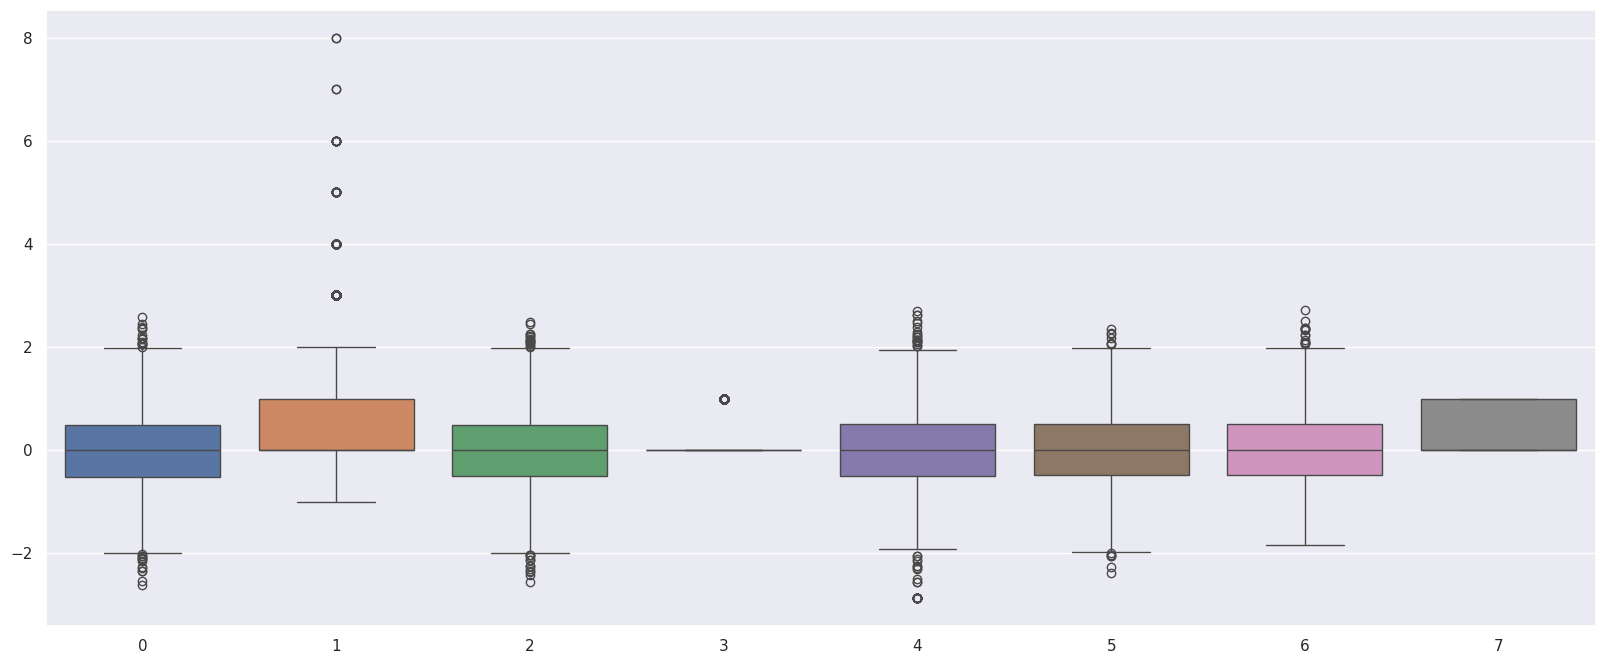

In [ ]:
sns.boxplot(X_train);

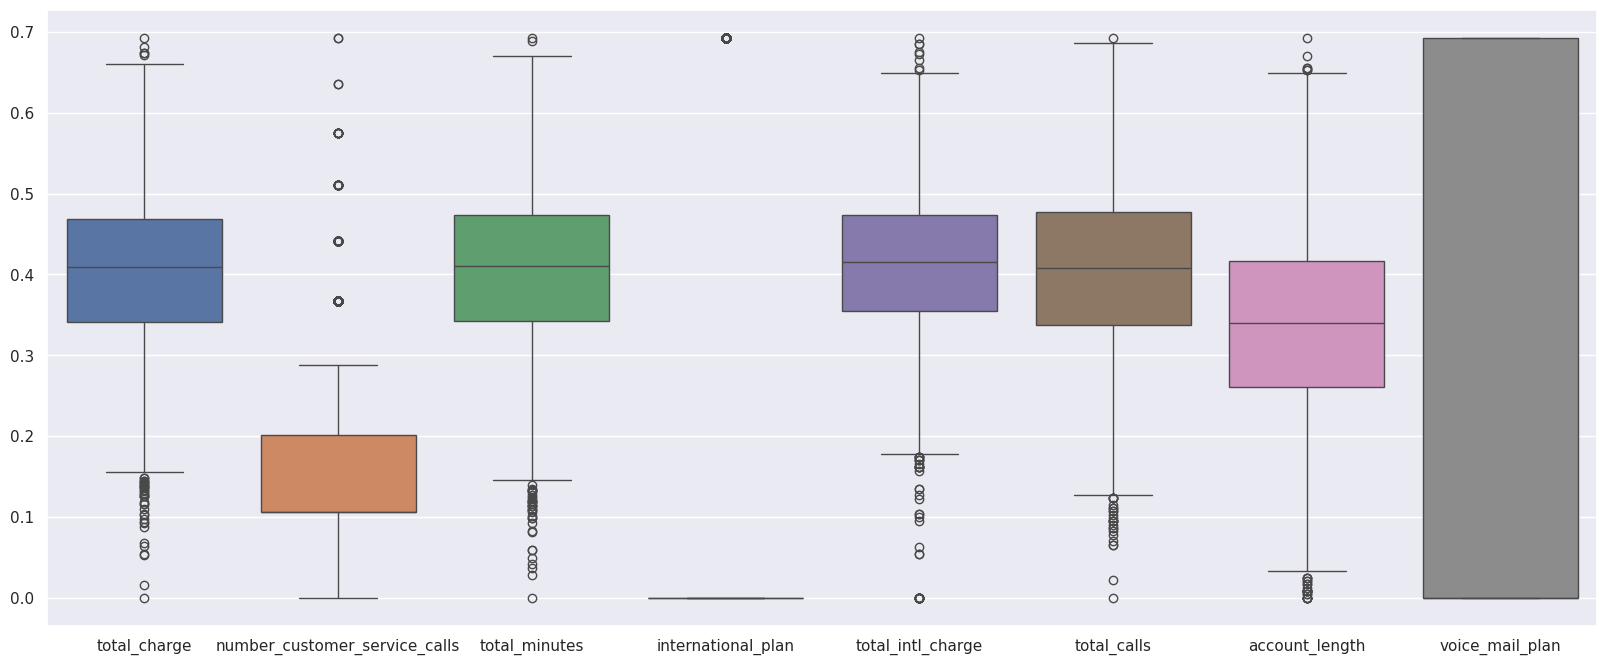

In [ ]:
sns.boxplot(X_train_log);

we need to rename columns and transform into dataframe again

In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.rename(columns=dict(enumerate(features_8)), inplace=True)
X_test.rename(columns=dict(enumerate(features_8)), inplace=True)

print(type(X_train))
print(type(X_test))
print(type(X_train_log))
print(type(X_test_log))
print(X_train.columns)
print(X_test.columns)
print(X_train_log.columns)
print(X_test_log.columns)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Index(['total_charge', 'number_customer_service_calls', 'total_minutes',
       'international_plan', 'total_intl_charge', 'total_calls',
       'account_length', 'voice_mail_plan'],
      dtype='object')
Index(['total_charge', 'number_customer_service_calls', 'total_minutes',
       'international_plan', 'total_intl_charge', 'total_calls',
       'account_length', 'voice_mail_plan'],
      dtype='object')
Index(['total_charge', 'number_customer_service_calls', 'total_minutes',
       'international_plan', 'total_intl_charge', 'total_calls',
       'account_length', 'voice_mail_plan'],
      dtype='object')
Index(['total_charge', 'number_customer_service_calls', 'total_minutes',
       'international_plan', 'total_intl_charge', 'total_calls',
       'account_length', 'voice_mail_plan'],
      dtype='object')


###5.5.2 Combined: SVM

In [ ]:
#Training
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

#Evaluating
accuracy_svm = accuracy(y_test, svm_predictions)
precision_svm = precision_score(y_test, svm_predictions)
recall_svm = recall_score(y_test, svm_predictions)

#Printing
print("SVM Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)

SVM Metrics:
Accuracy: 0.944
Precision: 1.0
Recall: 0.6


###5.5.3 Combined: LightGBM

In [ ]:
#Training
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(X_train, y_train)
lgb_predictions = lgb_classifier.predict(X_test)

#Evaluating
accuracy_lgb = accuracy(y_test, lgb_predictions)
precision_lgb = precision_score(y_test, lgb_predictions)
recall_lgb = recall_score(y_test, lgb_predictions)

#Printing
print("LightGBM Metrics:")
print("Accuracy:", accuracy_lgb)
print("Precision:", precision_lgb)
print("Recall:", recall_lgb)

[LightGBM] [Info] Number of positive: 478, number of negative: 2922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1032
[LightGBM] [Info] Number of data points in the train set: 3400, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140588 -> initscore=-1.810413
[LightGBM] [Info] Start training from score -1.810413
LightGBM Metrics:
Accuracy: 0.954
Precision: 0.9354838709677419
Recall: 0.725


###5.5.4 Combined Random Forest Classifier

In [ ]:
#training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_log, y_train)
rf_predictions = rf_classifier.predict(X_test_log)

#evaluating
accuracy_rf = accuracy(y_test, rf_predictions)
precision_rf = precision_score(y_test, rf_predictions)
recall_rf = recall_score(y_test, rf_predictions)

#printing
print("Baseline: Random Forest Metrics:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)

Baseline: Random Forest Metrics:
Accuracy: 0.854
Precision: 0.4885057471264368
Recall: 0.7083333333333334


###5.5.5 Results after combined transformations

In [ ]:
#creating a summary table of the results
tab = [['Model', 'Accuracy', 'Precision',  'Recall'],
      ['Random Forest', accuracy_rf, precision_rf, recall_rf],
      ['SVM', accuracy_svm, precision_svm, recall_svm],
      ['LightGBM', accuracy_lgb, precision_lgb, recall_lgb]]

print(tabulate(tab, headers='firstrow'))

#dataframe to rank performances
rf = pd.DataFrame({'Model Name':'Random Forest','Accuracy':accuracy_rf},index=[0])
svm = pd.DataFrame({'Model Name':'SVM','Accuracy':accuracy_svm},index=[0])
lgb = pd.DataFrame({'Model Name':'LightGBM','Accuracy':accuracy_lgb},index=[0])

result = pd.concat([rf, svm, lgb])
result = result.sort_values('Accuracy', ascending=False)
result

Model            Accuracy    Precision    Recall
-------------  ----------  -----------  --------
Random Forest       0.854     0.488506  0.708333
SVM                 0.944     1         0.6
LightGBM            0.954     0.935484  0.725


,Model Name,Accuracy
0,LightGBM,0.954
0,SVM,0.944
0,Random Forest,0.854


##5.6 Comparing All Performances

In [ ]:
#creating columns to know the method before comparing
result['method'] = 'combined'
baseline_result['method'] = 'baseline'
fs_result['method'] = 'feature selection'
outlier_result['method'] = 'outliers treatment'

#gathering all performances
all_performances = pd.concat([result, baseline_result, fs_result, outlier_result])
all_performances = all_performances.sort_values('Accuracy', ascending=False)
all_performances = all_performances.drop(columns='Method')
all_performances

,Model Name,Accuracy,method
0,LightGBM,0.954,combined
0,LightGBM,0.949,outliers treatment
0,SVM,0.944,combined
0,SVM,0.936,outliers treatment
0,SVM,0.911,feature selection
0,SVM,0.885,baseline
0,Random Forest,0.875,outliers treatment
0,Random Forest,0.866,baseline
0,LightGBM,0.865,baseline
0,Random Forest,0.862,feature selection


#6 K-fold Cross Validation

In [ ]:
model = lgb.LGBMClassifier()
kf = KFold(n_splits=5)
scores = []

In [ ]:
confusion_matrixes = []
#cross-validation
for trial_index, val_index in kf.split(X_train):
    X_trial, X_val = X_train.iloc[trial_index], X_train.iloc[val_index]
    y_trial, y_val = y_train.iloc[trial_index], y_train.iloc[val_index]
    model.fit(X_trial, y_trial)
    y_pred = model.predict(X_val)
    score = accuracy(y_val, y_pred)
    scores.append(score)
    print(f'Fold {len(scores)}, Accuracy: {score:.3f}')
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrixes.append(cm)

[LightGBM] [Info] Number of positive: 392, number of negative: 2328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 2720, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144118 -> initscore=-1.781503
[LightGBM] [Info] Start training from score -1.781503
Fold 1, Accuracy: 0.950
[LightGBM] [Info] Number of positive: 373, number of negative: 2347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 2720, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137132 -> initscor

In [ ]:
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f'Mean accuracy: {mean_score:.3f}, Standard deviation: {std_score:.3f}')

Mean accuracy: 0.959, Standard deviation: 0.006


Confusion Matrix for Fold 1:


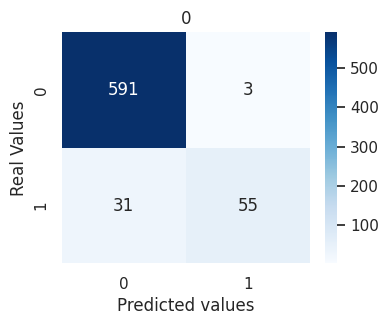

Confusion Matrix for Fold 2:


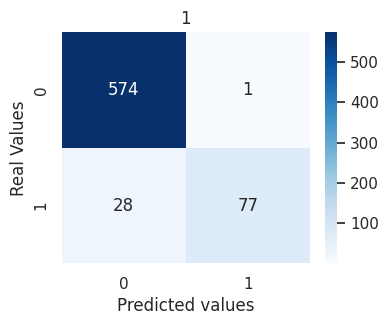

Confusion Matrix for Fold 3:


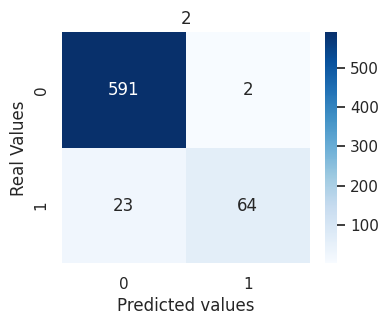

Confusion Matrix for Fold 4:


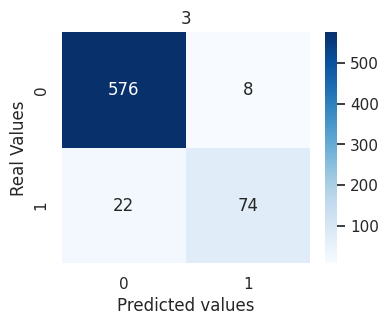

Confusion Matrix for Fold 5:


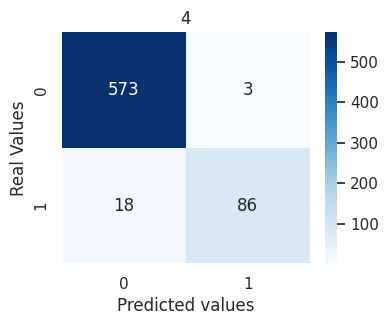

In [ ]:
#accessing the matrixes
for i, cm in enumerate(confusion_matrixes):
    print(f"Confusion Matrix for Fold {i+1}:")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted values')
    plt.ylabel('Real Values')
    plt.title(i)
    plt.show()

#7 Communicating Results

*   It has been able to reach an **accuracy of approximately 96% (95,9% specifically)** after processing the dataset.

*   As deploy, **this model can be used for applying in new cases**, as the example that follows with the "test" dataset

*   With EDA and feature selection, it has been found out that 4 main reasons impact on whether a customer is a potential churn:

    1.   **Charges:** By speanding 40 dollars or more per month, a customer may consider cancelling
    2.   **International plan signup:** Customers with international plan are 4 times more likely to cancel than a regular one
    3.   **Number of times has called Customer Service:** By calling 4 times, a customer gets unsatisfied, and likely to cancel. The more times one has to call, the more likely is to become a churn
    4.   **Minutes on calls:** The more a customer spends on the phone, the more one will be charged for that service, which can lead to be more likely to cancel




* Besides predicting churns, here are some potential actions to be taken in order to reduce customer loss after what it has been found out:

    1.   For customers **who spend more than 40 dollars, give special offers**, so their plans get less pricey

    2.   Clients **with international plan** might consider canceling, so **special packs or prices** can reduce this number

    3.   **Making sure a customer does not have to call more than once the customer service** to solve his or her issue
